In [1]:
%cd /workdir/hdd29/chloroplast_genome_evaluation

/local/workdir/hdd29/chloroplast_genome_evaluation


In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns
from Bio import SeqIO
from Bio import SeqUtils
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from pandarallel import pandarallel
from sklearn.decomposition import PCA
import numpy as np
import glob
import ast
from collections import Counter



pandarallel.initialize()


INFO: Pandarallel will run on 44 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.read_csv("data/taxonomy_info.csv")

In [5]:
#get the genome sequence and compute length and GC
genomes_dir = "data/genomes"

def get_genome(fileBasename, genome_dir):
    genome_file = os.path.join(genome_dir, fileBasename + ".fa")
    if not os.path.exists(genome_file):
        print(f"Genome file {genome_file} does not exist.")
        return None, None
    
    genome_seq = SeqIO.read(genome_file, "fasta")
    return genome_seq.seq

df["Genome"] = df["FileBasename"].parallel_apply(lambda x: get_genome(x, genomes_dir))
df["geno_genomeLength"] = df["Genome"].parallel_apply(lambda x: len(x) if x is not None else 0)
df["geno_genomicGC"] = df["Genome"].parallel_apply(lambda x: SeqUtils.gc_fraction(x) if x is not None else 0)



In [6]:
#how many NA genomes, genomeLength, and genomic GC
df["Genome"].isna().sum()
df["geno_genomeLength"].isna().sum()
df["geno_genomicGC"].isna().sum()
df.describe()

,Year,geno_genomeLength,geno_genomicGC,accD,atpA,atpB,atpE,atpF,atpH,atpI,...,geno_dinucleotide_TA,geno_dinucleotide_TC,geno_dinucleotide_TT,geno_dinucleotide_TG,geno_dinucleotide_GA,geno_dinucleotide_GC,geno_dinucleotide_GT,geno_dinucleotide_GG,DistanceToCentroid,geneCount
count,20070.000000,2.007000e+04,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,...,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000,20070.000000
mean,2021.369407,1.533128e+05,0.371497,0.821624,0.970802,0.989088,0.944046,0.940558,0.967862,0.953363,...,0.080668,0.067853,0.114218,0.054269,0.065542,0.030000,0.044855,0.043198,0.013048,120.720977
std,2.635507,1.998412e+04,0.021377,0.382838,0.168365,0.103891,0.229839,0.236456,0.176370,0.210865,...,0.007956,0.004778,0.009010,0.001994,0.004268,0.002887,0.001843,0.004517,0.015278,20.764771
min,1998.000000,6.340000e+02,0.137667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027881,0.029779,0.047921,0.025847,0.023959,0.006432,0.023120,0.008503,0.001561,0.000000
25%,2020.000000,1.512845e+05,0.366571,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.077106,0.067123,0.110578,0.053366,0.064567,0.028731,0.044180,0.041941,0.006020,124.000000
50%,2022.000000,1.553510e+05,0.373887,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.079380,0.068611,0.113143,0.054271,0.066555,0.029622,0.044778,0.043429,0.008074,127.000000
75%,2023.000000,1.590848e+05,0.380055,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.082503,0.070445,0.116111,0.055267,0.067469,0.030574,0.045318,0.045277,0.012791,130.000000
max,2025.000000,1.351631e+06,0.576640,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.167296,0.080771,0.231440,0.076662,0.077402,0.084512,0.071708,0.099290,0.207491,188.000000


Throw a flag on genome length - min and max present obvious grounds for filtering. 

Year looks pretty reasonable, in fact. 

In [7]:
#gene presence/absence, then count
gbfs_dir = "data/gbfs"

def get_gene_names_from_gbf(gbf_file):
    """
    Count the number of gene features in a GenBank file.

    Parameters:
        gbf_file (str): Path to the GenBank file.

    Returns:
        list (str): List of gene names.
    """
    genes = []

    if not os.path.exists(gbf_file):
        print(f"GBF file {gbf_file} does not exist.")
        return genes

    for record in SeqIO.parse(gbf_file, "genbank"):
        for feature in record.features:
            if feature.type == "gene":
                genes += [feature.qualifiers.get("gene", [""])[0]]

    return genes

"""
for file in tqdm(df["FileBasename"].to_list()[1:10]):
    gbf_file = os.path.join(gbfs_dir, file + "fa.gbf")
    if not os.path.exists(gbf_file):
        print(f"GBF file {gbf_file} does not exist.")
        continue

    genes = get_gene_names_from_gbf(gbf_file)
"""

df["Genes"] = df["FileBasename"].parallel_apply(lambda x: get_gene_names_from_gbf(os.path.join(gbfs_dir, x + "fa.gbf")))

mlb = MultiLabelBinarizer()
gene_matrix = pd.DataFrame(
    mlb.fit_transform(df["Genes"]),
    columns=mlb.classes_,
    index=df.index
)
df = pd.concat([df, gene_matrix], axis=1)

df["geno_geneCount"] = df[mlb.classes_].sum(axis=1)
df["geno_geneCount"].describe()


count    20070.000000
mean       202.276134
std         33.897544
min          0.000000
25%        208.000000
50%        212.000000
75%        216.000000
max        224.000000
Name: geno_geneCount, dtype: float64

Looks Like gene loss/absence really explains some variation in the data, i would bet this is due to the inclusion of non-plant samples with wacky gene sets

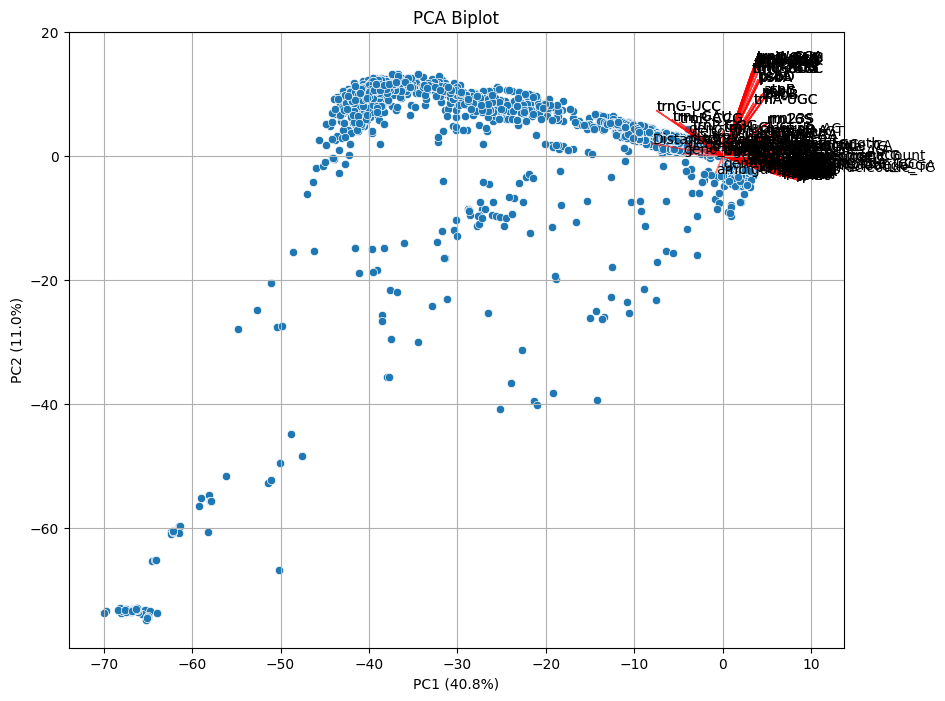

Variance explained: PC1=40.8%, PC2=11.0%
Columns included in PCA:
 ['Year', 'geno_genomeLength', 'geno_genomicGC', 'accD', 'atpA', 'atpB', 'atpE', 'atpF', 'atpH', 'atpI', 'ccsA', 'cemA', 'clpP', 'infA', 'matK', 'ndhA', 'ndhB', 'ndhC', 'ndhD', 'ndhE', 'ndhF', 'ndhG', 'ndhH', 'ndhI', 'ndhJ', 'ndhK', 'petA', 'petB', 'petD', 'petG', 'petL', 'petN', 'psaA', 'psaB', 'psaC', 'psaI', 'psaJ', 'psbA', 'psbB', 'psbC', 'psbD', 'psbE', 'psbF', 'psbH', 'psbI', 'psbJ', 'psbK', 'psbL', 'psbM', 'psbN', 'psbT', 'psbZ', 'rbcL', 'rpl14', 'rpl16', 'rpl2', 'rpl20', 'rpl22', 'rpl23', 'rpl32', 'rpl33', 'rpl36', 'rpoA', 'rpoB', 'rpoC1', 'rpoC2', 'rps11', 'rps12', 'rps14', 'rps15', 'rps16', 'rps18', 'rps19', 'rps2', 'rps3', 'rps4', 'rps7', 'rps8', 'rrn16S', 'rrn23S', 'rrn4.5S', 'rrn5S', 'trnA-UGC', 'trnC-GCA', 'trnD-GUC', 'trnE-UUC', 'trnF-GAA', 'trnG-GCC', 'trnG-UCC', 'trnH-GUG', 'trnI-AAU', 'trnI-GAU', 'trnK-UUU', 'trnL-CAA', 'trnL-GAG', 'trnL-UAA', 'trnL-UAG', 'trnM-CAU', 'trnN-GUU', 'trnP-GGG', 'trnP-UGG', 

In [8]:
num_df = df.select_dtypes(include=[np.number])
scaled = StandardScaler().fit_transform(num_df)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled)

plt.figure(figsize=(10,8))
sns.scatterplot(x=scores[:,0], y=scores[:,1])
scale = 100
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, x*scale, y*scale, color='r', alpha=0.5, head_width=0.05)
    plt.text(x*(scale+0.2), y*(scale+0.2), num_df.columns[i], fontsize=10)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Biplot")
plt.grid(True)
plt.show()

print(f"Variance explained: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")
loadings = pd.DataFrame(pca.components_.T, index=num_df.columns, columns=["PC1", "PC2"])
print("Columns included in PCA:\n", num_df.columns.tolist())


So the first PC is loading on gene count, the second on a bunch of tRNAS 

Process the TRY data in R, since they have their own package for loading their data format

/workdir/hdd29/chloroplast_genome_evaluation/src/XXX_processTRYData.R

In [13]:
#nitrogen status and photosynthetic pathway - load the csvs. Species labels are Organism in df, 
# and AccSpeciesName in these data.

nitrogen_df = pd.read_csv("data/fixationStatus.csv")
nitrogen_df = nitrogen_df.rename(columns={"AccSpeciesName": "Organism"}) #FixationLabel is the value name 
photosynthetic_df = pd.read_csv("data/photosyntheticPathways.csv")
photosynthetic_df = photosynthetic_df.rename(columns={"AccSpeciesName": "Organism"})
photosynthetic_df = photosynthetic_df.rename(columns={"OrigValueStr": "photosyntheticPathway"})

print(nitrogen_df["Organism"].duplicated().sum())
print(photosynthetic_df["Organism"].duplicated().sum())

nitrogen_df = nitrogen_df.drop_duplicates(subset="Organism")
photosynthetic_df = photosynthetic_df.drop_duplicates(subset="Organism")

print(nitrogen_df["Organism"].duplicated().sum())
print(photosynthetic_df["Organism"].duplicated().sum())
# Merge nitrogen status and photosynthetic pathway data with the main dataframe
# dont add any rows to the main dataframe, just make new columns for the new values, and put NA if the value is not present

df = df.merge(nitrogen_df[["Organism", "FixationLabel"]], on="Organism", how="left")
df = df.merge(photosynthetic_df[["Organism", "photosyntheticPathway"]], on="Organism", how="left")


0
0
0
0


In [14]:
fix_df = df[~df["FixationLabel"].isna()]
fix_df["FixationLabel_enc"] = fix_df["FixationLabel"].astype('category').cat.codes

dupes = fix_df.columns[fix_df.columns.duplicated()]
print(dupes)
fix_df = fix_df.loc[:, ~fix_df.columns.duplicated()]

#keep distinct organisms
fix_df = fix_df.drop_duplicates(subset="Organism")
#how many samples 
print(f"Number of samples with fixation label: {fix_df.shape[0]}")

numeric_cols = fix_df.select_dtypes(include="number").columns
print(len(numeric_cols))
corr_fix = fix_df[numeric_cols].corrwith(fix_df["FixationLabel_enc"]).sort_values(key=abs, ascending=False)

print(corr_fix.head(10))


Index(['accD', 'atpA', 'atpB', 'atpE', 'atpF', 'atpH', 'atpI', 'ccsA', 'cemA',
       'clpP',
       ...
       'trnT-UGU', 'trnV-GAC', 'trnV-UAC', 'trnW-CCA', 'trnY-GUA', 'ycf1',
       'ycf15', 'ycf2', 'ycf3', 'ycf4'],
      dtype='object', length=120)
Number of samples with fixation label: 2436
144
FixationLabel_enc       1.000000
rpl22                  -0.737344
geno_dinucleotide_CT   -0.602510
geno_dinucleotide_CC   -0.527622
geno_dinucleotide_AT    0.524533
geno_genomicGC         -0.523528
geno_dinucleotide_GT   -0.499364
geno_dinucleotide_GC   -0.495366
geno_dinucleotide_TA    0.482311
trnS-CGA               -0.471598
dtype: float64


/tmp/ipykernel_1732506/3998551399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_df["FixationLabel_enc"] = fix_df["FixationLabel"].astype('category').cat.codes


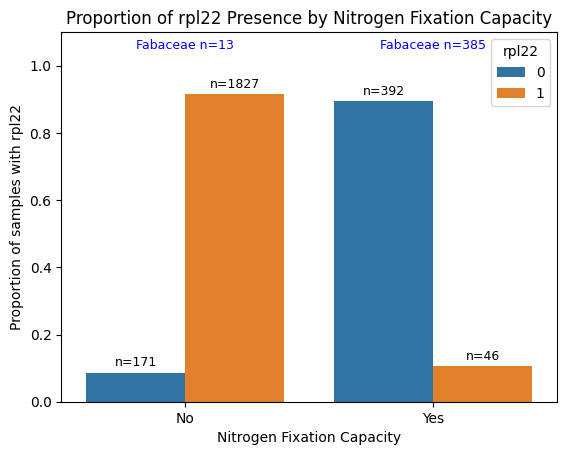

In [15]:
prop_df = fix_df.groupby(['FixationLabel', 'rpl22']).size().reset_index(name='count')
total = prop_df.groupby('FixationLabel')['count'].transform('sum')
prop_df['proportion'] = prop_df['count'] / total

prop_df['label'] = prop_df['count'].astype(str)

sns.barplot(data=prop_df, x='FixationLabel', y='proportion', hue='rpl22')
for i, row in prop_df.iterrows():
    x = list(prop_df['FixationLabel'].unique()).index(row['FixationLabel'])
    hue_offset = -0.2 if row['rpl22'] == 0 else 0.2
    plt.text(x + hue_offset, row['proportion'] + 0.02, f"n={row['count']}", ha='center', fontsize=9)

fabaceae_counts = fix_df[fix_df["Taxonomy"].str.contains("Fabaceae", na=False)].groupby("FixationLabel").size()

for i, fix_label in enumerate(prop_df['FixationLabel'].unique()):
    count = fabaceae_counts.get(fix_label, 0)
    plt.text(i, 1.05, f"Fabaceae n={count}", ha='center', fontsize=9, color='blue')

plt.title('Proportion of rpl22 Presence by Nitrogen Fixation Capacity')
plt.xlabel('Nitrogen Fixation Capacity')
plt.ylabel('Proportion of samples with rpl22')
plt.ylim(0, 1.1)
plt.show()


In [16]:
#how many genes in the df total have lost rpl22
df["rpl22"] == 0

,rpl22,rpl22
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
20065,False,False
20066,False,False
20067,True,True
20068,False,False


In [17]:
def get_degenerate_codon_GC(CDS):
    if len(CDS) < 3:
        return None
    if CDS[:3] not in {"ATG", "GTG", "ACA"}:
        return None

            #fourfold degenerate codons: 
    #A, GCN
    #R, CGN
    #G, GGN
    #L, CTN
    #P, CCN
    #S, TCN
    #T, ACN
    #V, GTN

    fourfold_codons = {
        "CTN", "CCN", "ACN", "GCN", "GGN", "TCN", "GTN", "CGN"
    }

    CDS = CDS.upper()
    codons = [CDS[i:i+3] for i in range(0, len(CDS), 3)]

    gc_count = 0
    total_count = 0
    for codon in codons:
        if len(codon) < 3:
            continue
        # Check if codon matches fourfold degenerate pattern (3rd base can vary)
        pattern = codon[:2] + "N"
        if pattern in fourfold_codons:
            base = codon[2]
            if base in {"G", "C"}:
                gc_count += 1
            total_count += 1

    if total_count == 0:
        return None
    return gc_count / total_count

assert 1 == get_degenerate_codon_GC("ATGCATCATGTG")
assert .5 == get_degenerate_codon_GC("ATGCATCATGTGGTA")



In [18]:
#the list of genes is the total set of gene_matrix colnames
genes = gene_matrix.columns.tolist()
print(genes)
print(len(genes))

['accD', 'atpA', 'atpB', 'atpE', 'atpF', 'atpH', 'atpI', 'ccsA', 'cemA', 'clpP', 'infA', 'matK', 'ndhA', 'ndhB', 'ndhC', 'ndhD', 'ndhE', 'ndhF', 'ndhG', 'ndhH', 'ndhI', 'ndhJ', 'ndhK', 'petA', 'petB', 'petD', 'petG', 'petL', 'petN', 'psaA', 'psaB', 'psaC', 'psaI', 'psaJ', 'psbA', 'psbB', 'psbC', 'psbD', 'psbE', 'psbF', 'psbH', 'psbI', 'psbJ', 'psbK', 'psbL', 'psbM', 'psbN', 'psbT', 'psbZ', 'rbcL', 'rpl14', 'rpl16', 'rpl2', 'rpl20', 'rpl22', 'rpl23', 'rpl32', 'rpl33', 'rpl36', 'rpoA', 'rpoB', 'rpoC1', 'rpoC2', 'rps11', 'rps12', 'rps14', 'rps15', 'rps16', 'rps18', 'rps19', 'rps2', 'rps3', 'rps4', 'rps7', 'rps8', 'rrn16S', 'rrn23S', 'rrn4.5S', 'rrn5S', 'trnA-UGC', 'trnC-GCA', 'trnD-GUC', 'trnE-UUC', 'trnF-GAA', 'trnG-GCC', 'trnG-UCC', 'trnH-GUG', 'trnI-AAU', 'trnI-GAU', 'trnK-UUU', 'trnL-CAA', 'trnL-GAG', 'trnL-UAA', 'trnL-UAG', 'trnM-CAU', 'trnN-GUU', 'trnP-GGG', 'trnP-UGG', 'trnQ-UUG', 'trnR-ACG', 'trnR-CCG', 'trnR-CCU', 'trnR-UCG', 'trnR-UCU', 'trnS-CGA', 'trnS-GCU', 'trnS-GGA', 'trnS-

In [19]:
def get_gene_DNA_from_gbf(gene_name,gbf_file):
    """
    Get the DNA sequence of a gene from the GenBank file.
    """
    ret = ""
    if not os.path.exists(gbf_file):
        #print(f"GBF file {gbf_file} does not exist.")
        return None

    with open(gbf_file, "r") as handle:
        for record in SeqIO.parse(handle, "genbank"):
            for feature in record.features:
                if feature.type == "CDS" and "gene" in feature.qualifiers:
                    if gene_name in feature.qualifiers["gene"]:
                        # Extract the DNA sequence
                        dna_sequence = str(feature.location.extract(record.seq))
                        ret = dna_sequence
                #handle tRNA and rRNA as well
                elif feature.type in {"tRNA", "rRNA"} and "gene" in feature.qualifiers:
                    if gene_name in feature.qualifiers["gene"]:
                        # Extract the DNA sequence
                        dna_sequence = str(feature.location.extract(record.seq))
                        ret = dna_sequence
    if ret:
        return ret
    else:
        #print(f"Gene {gene_name} not found in {gbf_file}.")
        return None

def get_gene_AA_from_gbf(gene_name, gbf_file):
    """
    Get the AA sequence of a gene from the GenBank file.
    Tries matching by 'gene', 'locus_tag', or 'product' qualifiers.
    Returns the first matching AA sequence or None.
    """
    if not os.path.exists(gbf_file):
        return None

    gene_name = gene_name.lower()

    with open(gbf_file, "r") as handle:
        for record in SeqIO.parse(handle, "genbank"):
            for feature in record.features:
                if feature.type != "CDS":
                    continue
                if "translation" not in feature.qualifiers:
                    continue

                # Normalize all candidate identifiers
                gene_vals = [val.lower() for key in ["gene", "locus_tag", "product"]
                             if key in feature.qualifiers
                             for val in feature.qualifiers[key]]

                if any(gene_name == val or gene_name in val for val in gene_vals):
                    return feature.qualifiers["translation"][0]

    return None

In [20]:
#test that getting AA's works,
test_gene = "psbA"
test_gbf_file = os.path.join(gbfs_dir, "NC0016662fa.gbf")
print(f"Testing gene {test_gene} in file {test_gbf_file}")
test_aa = get_gene_AA_from_gbf(test_gene, test_gbf_file)
print(test_aa)

Testing gene psbA in file data/gbfs/NC0016662fa.gbf
MTAILERRESTSLWGRFCNWITSTENRLYIGWFGVLMIPTLLTATSVFIIAFIAAPPVDIDGIREPVSGSLLYGNNIISGAIIPTSAAIGLHFYPIWEAASVDEWLYNGGPYELIVLHFLLGVACYMGREWELSFRLGMRPWIAVAYSAPVAAATAVFLIYPIGQGSFSDGMPLGISGTFNFMIVFQAEHNILMHPFHMLGVAGVFGGSLFSAMHGSLVTSSLIRETTENESANEGYKFGQEEETYNIVAAHGYFGRLIFQYASFNNSRSLHFFLAAWPVVGIWFTALGISTMAFNLNGFNFNQSVVDSQGRVINTWADIINRANLGMEVMHERNAHNFPLDLAALEVPYLNG


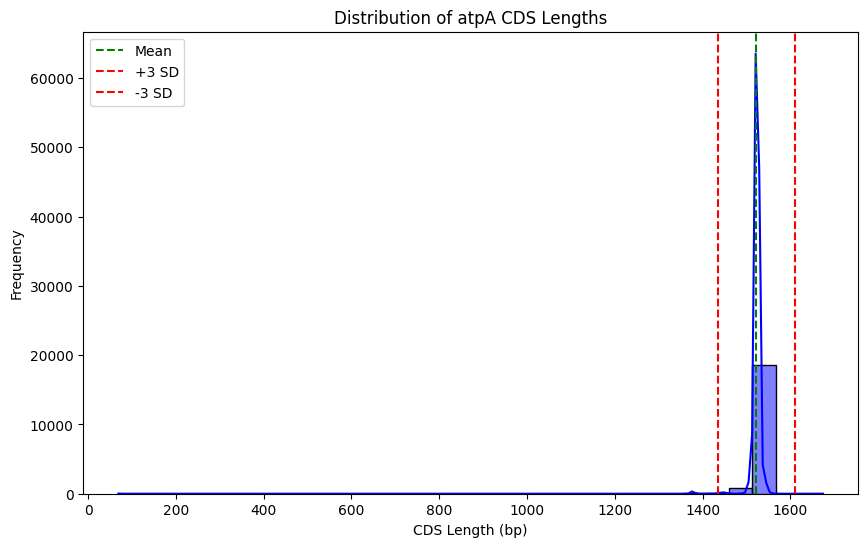

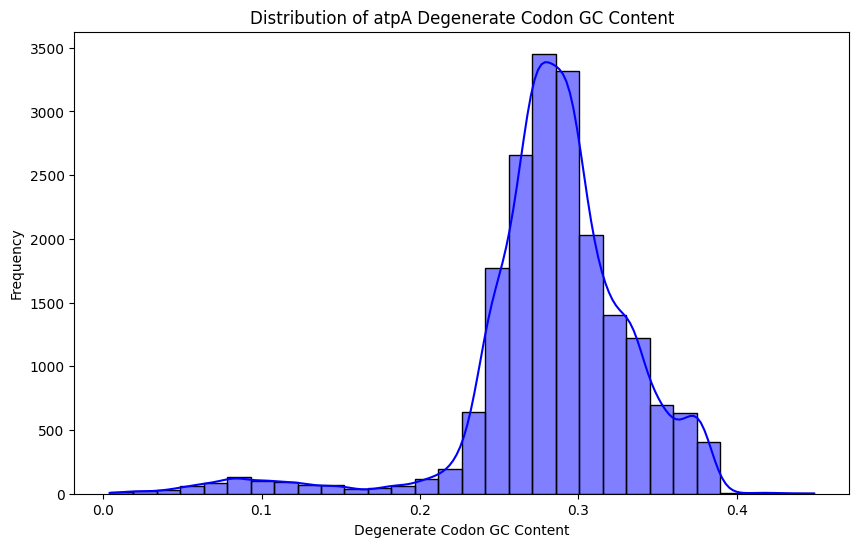

In [21]:
#let's begin with atpA

#get all the CDS sequences for atpA and store them in atpA_CDS

df["atpA_CDS"] = df["FileBasename"].parallel_apply(lambda x: get_gene_DNA_from_gbf("atpA", os.path.join(gbfs_dir, x + "fa.gbf")))

#detect outliers by filtering for sequences that are too short or too long, +/- 3sds 

#mark the outliers in "atpA_outlier" column

atpA_CDS_lengths = df["atpA_CDS"].str.len()
atpA_CDS_mean = atpA_CDS_lengths.mean()
atpA_CDS_std = atpA_CDS_lengths.std()
df["atpA_outlier"] = (atpA_CDS_lengths < (atpA_CDS_mean - 3 * atpA_CDS_std)) | (atpA_CDS_lengths > (atpA_CDS_mean + 3 * atpA_CDS_std))

#plot a hist of the lengths, color the outliers in red
plt.figure(figsize=(10,6))
sns.histplot(atpA_CDS_lengths, bins=30, kde=True, color='blue')
plt.axvline(atpA_CDS_mean, color='green', linestyle='dashed', label='Mean')
plt.axvline(atpA_CDS_mean + 3 * atpA_CDS_std, color='red', linestyle='dashed', label='+3 SD')
plt.axvline(atpA_CDS_mean - 3 * atpA_CDS_std, color='red', linestyle='dashed', label='-3 SD')
plt.title('Distribution of atpA CDS Lengths')
plt.xlabel('CDS Length (bp)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#for all atpA_CDS that are not outliers, get the degenerate codon GC content and store in atpA_degenerate_GC column
df["atpA_degenerate_GC"] = df.apply(lambda row: get_degenerate_codon_GC(row["atpA_CDS"]) if not row["atpA_outlier"] and row["atpA_CDS"] is not None else None, axis=1)
#plot a hist of the degenerate GC content
plt.figure(figsize=(10,6))
sns.histplot(df["atpA_degenerate_GC"].dropna(), bins=30, kde=True, color='blue')
plt.title('Distribution of atpA Degenerate Codon GC Content')
plt.xlabel('Degenerate Codon GC Content')
plt.ylabel('Frequency')
plt.show()

In [22]:
#print the CDS of the bottom 10 atpA_degenerate_GC values  
print(df.sort_values(by="atpA_degenerate_GC").head(10)[["Organism", "atpA_degenerate_GC", "atpA_CDS"]])

                                      Organism  atpA_degenerate_GC  \
18818                    Tetradesmus arenicola            0.004132   
2856              Tetradesmus major f. lunatus            0.008264   
18822                     Tetradesmus obliquus            0.008264   
2853   Tetradesmus obliquus var. spiraliformis            0.008264   
2855      Tetradesmus dissociatus f. oviformis            0.008264   
18823                      Tetradesmus reginae            0.008264   
18820                    Tetradesmus dimorphus            0.012397   
18821                    Tetradesmus distendus            0.012448   
16475                Pseudopediastrum integrum            0.016000   
10339                        Dunaliella salina            0.016393   

                                                atpA_CDS  
18818  ATGGTTGATTTTGGTATTGTATTCCAAGTTGGTGATGGAATTGCTC...  
2856   ATGGTTGATTTTGGTATTGTATTCCAAGTTGGTGATGGAATTGCTC...  
18822  ATGGTTGACTTTGGTATTGTATTCCAAGTTGGTGATGGAATTGCT

In [ ]:
genes = gene_matrix.columns.tolist()
for g in tqdm(genes):
    df[f"{g}_CDS"] = df["FileBasename"].parallel_apply(lambda x: get_gene_DNA_from_gbf(g, os.path.join(gbfs_dir, x + "fa.gbf")))
    lengths = df[f"{g}_CDS"].str.len()
    m, s = lengths.mean(), lengths.std()
    df[f"{g}_outlier"] = (lengths < m-3*s) | (lengths > m+3*s)
    #if the gene is not tRNA or rRNA, get the degenerate codon GC content and store in the column (trn or rrn in gene name)
    #if "trn" not in g and "rrn" not in g:
    #    df[f"{g}_degenerate_GC"] = df.apply(lambda r: get_degenerate_codon_GC(r[f"{g}_CDS"]) if not r[f"{g}_outlier"] and r[f"{g}_CDS"] else None, axis=1)


  5%|▌         | 6/120 [00:53<16:56,  8.91s/it]Process ForkPoolWorker-564:
Process ForkPoolWorker-570:
Process ForkPoolWorker-557:
Process ForkPoolWorker-571:
Process ForkPoolWorker-545:
Process ForkPoolWorker-567:
Process ForkPoolWorker-544:
Process ForkPoolWorker-580:
Process ForkPoolWorker-576:
Process ForkPoolWorker-566:
Process ForkPoolWorker-562:
Process ForkPoolWorker-551:
Process ForkPoolWorker-569:
Process ForkPoolWorker-581:
Process ForkPoolWorker-553:
Process ForkPoolWorker-584:
Process ForkPoolWorker-543:
Process ForkPoolWorker-583:
Process ForkPoolWorker-575:
Process ForkPoolWorker-559:
Process ForkPoolWorker-561:
Process ForkPoolWorker-560:
Process ForkPoolWorker-550:
Process ForkPoolWorker-546:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-563:
Process ForkPoolWorker-565:
Process ForkPoolWorker-542:
Process ForkPoolWorker

KeyboardInterrupt: 

  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
Traceback (most recent call last):
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/ch

  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/chloroplast_genome_evaluation/.pixi/envs/default/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/workdir/hdd29/chloroplast_genom

In [ ]:
#Now we're really getting into analytical territory, and we will want to pick the representative genome for each orgnism 
genomes_dir = "/workdir/hdd29/chloroplast_genome_evaluation/data/genomes"

def count_ambiguous_bases(seq_record):
    """
    Count ambiguous bases (N's) in a sequence record.
    
    Parameters:
        seq_record (SeqRecord): A Biopython SeqRecord object.
        
    Returns:
        int: Number of ambiguous bases in the sequence.
    """
    return seq_record.seq.count('N')

df['ambiguous_bases'] = 0  # Initialize the column

for f in tqdm(df['FileBasename'].to_list()):
    try: 
        genome_path = os.path.join(genomes_dir, f+".fa")

        Ns= count_ambiguous_bases(SeqIO.read(genome_path, "fasta"))
        df.loc[df['FileBasename'] == f, 'ambiguous_bases'] = Ns
    except Exception as e:
        print(f"Error processing file {f}: {e}")
        continue

df['ambiguous_bases'].describe()

/tmp/ipykernel_4080150/1642359074.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ambiguous_bases'] = 0  # Initialize the column
100%|██████████| 53525/53525 [02:57<00:00, 301.94it/s]


count    53525.000000
mean         3.636263
std        115.785949
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      18325.000000
Name: ambiguous_bases, dtype: float64

In [ ]:
dinucs = [a+b for a in 'ACTG' for b in 'ACTG']

def compute_freq(seq):
    counts = dict.fromkeys(dinucs, 0)
    for i in range(len(seq)-1):
        dp = seq[i:i+2]
        if dp in counts:
            counts[dp] += 1
    total = sum(counts.values())
    return {f"geno_dinucleotide_{dp}": counts[dp]/total if total>0 else 0 for dp in dinucs}

freq_df = df['Genome'].parallel_apply(compute_freq).apply(pd.Series)
df = pd.concat([df, freq_df], axis=1)

dinucs_prefixed = [f"geno_dinucleotide_{a+b}" for a in 'ACTG' for b in 'ACTG']
centroid = df[dinucs_prefixed].mean()
df['DistanceToCentroid'] = np.linalg.norm(df[dinucs_prefixed] - centroid, axis=1)

<Axes: xlabel='DistanceToCentroid', ylabel='Frequency'>

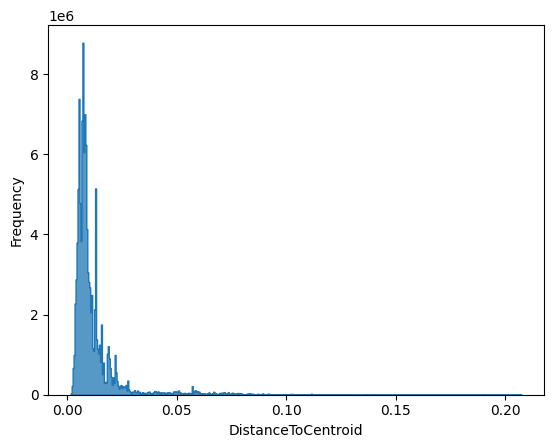

In [ ]:
sns.histplot(data=df, x="DistanceToCentroid", element="step", stat="frequency", common_norm=False)

In [ ]:
df["Genes"].head()


0    [psbA, trnK-UUU, matK, trnQ-UUG, psbK, psbI, t...
1    [trnH-GUG, psbA, trnK-UUU, matK, rps16, trnQ-U...
2    [trnH-GUG, psbA, trnK-UUU, matK, rps16, trnQ-U...
3    [trnH-GUG, psbA, trnK-UUU, matK, rps16, trnQ-U...
4    [trnH-GUG, psbA, trnK-UUU, matK, rps16, trnQ-U...
Name: Genes, dtype: object

In [ ]:
selected_genomes = df[df.duplicated("Organism", keep=False) == False]
print(f"Selected genomes shape: {selected_genomes.shape}")
#drop all genomes with less than 50 genes


#remove all the selected genomes from the original dataframe
df_remaining = df[df.duplicated("Organism", keep=False)]

df["geno_geneCount"] = df["Genes"].apply(len)

tech_priority = ['PacBio', 'Oxford Nanopore', 'Illumina', '454/Roche', 'Sanger', 'Ion Torrent']
df_remaining['tech_rank'] = df_remaining['SequencingTech'].map({t: i for i, t in enumerate(tech_priority)}).fillna(len(tech_priority))

df_remaining = df_remaining.sort_values(
    by=['Organism', 'geno_geneCount', 'ambiguous_bases', 'tech_rank','Year', "DistanceToCentroid"],
    ascending=[True, False, True, False, True, True]  # Corrected the ascending order for 'DistanceToCentroid' to True
)

best_per_org = df_remaining.groupby('Organism').head(1)

selected_genomes = pd.concat([selected_genomes, best_per_org]).drop(columns='tech_rank')

print(selected_genomes.shape)
#write the Ids selected to a file
selected_genomes.to_csv("data/selected_genomes.csv", index=False)
selected_Ids = selected_genomes["FileBasename"].tolist()

# Save the selected genomes to a txt file
with open("data/selectedGenomesOnBasisOfInOrder_GeneCount_AmbiguousBases_Tech_Year_DistanceToDinucCentroid.txt", "w") as f:
    for genome_id in selected_Ids:
        f.write(f"{genome_id}\n")


Selected genomes shape: (5771, 392)


/tmp/ipykernel_4080150/1257244256.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remaining['tech_rank'] = df_remaining['SequencingTech'].map({t: i for i, t in enumerate(tech_priority)}).fillna(len(tech_priority))


(20070, 392)


Now, we can continue with one sample per species. We need to align genes.  

In [31]:
#checkpoint 1 - pre alignment
df = pd.read_csv("data/selected_genomes.csv")
print(df.shape)

(20070, 392)


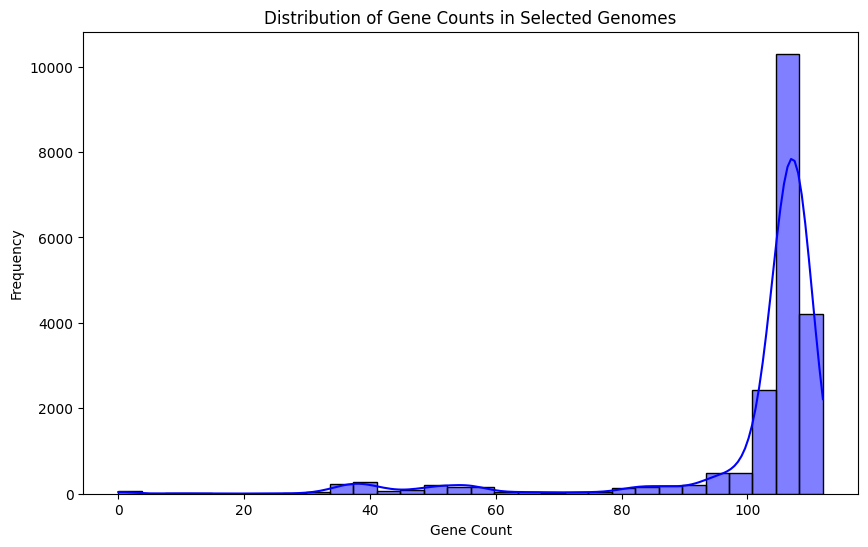

In [25]:
#plot the histogram of geno_geneCount
plt.figure(figsize=(10,6))
sns.histplot(df["geno_geneCount"], bins=30, kde=True, color='blue')
plt.title('Distribution of Gene Counts in Selected Genomes')
plt.xlabel('Gene Count')
plt.ylabel('Frequency')
plt.show()

In [32]:
#great, now we need to merge this data with the phenotypic data
df["mergeOrganism"] = df["Organism"].str.replace(r'\W+', '', regex=True).str.replace(' ', '', regex=False)

pheno_df = pd.read_csv("data/pheno.csv")

# Merge the phenotypic data with the genomic data
#first, how many terms are in pheno_df["queryTerm"]
pheno_terms = pheno_df["queryTerm"].nunique()
print(f"Number of unique phenotypic samples: {pheno_terms}")
#rename all the pheno columns to begin with _pheno
pheno_df = pheno_df.rename(columns=lambda x: f"pheno_{x}" if x != "queryTerm" else x)

#also remove all non-alphanumeric characters from pheno_df["species"]
pheno_df["mergeQueryTerm"] = pheno_df["queryTerm"].str.replace(r'\W+', '', regex=True).str.replace(' ', '', regex=False)

#how many terms in mergeOrganism are present in pheno_df["queryTerm"]
pheno_terms_in_merge = df["mergeOrganism"].isin(pheno_df["mergeQueryTerm"]).sum()
print(f"Number of mergeOrganism terms present in phenotypic data: {pheno_terms_in_merge}")

#print the columns in pheno_df
print(pheno_df.columns)

# Merge the dataframes on the mergeOrganism column and queryTerm column
merged_df = df.merge(pheno_df, left_on="mergeOrganism", right_on="mergeQueryTerm", how="left")
print(f"Merged dataframe shape: {merged_df.shape}")

df = merged_df.copy()

#filter the df to only include samples with Streptophyta in the Taxonomy column, and gene count > 100 
df_filtered = df[(df['Taxonomy'].str.contains('Viridiplantae', na=False)) & (df['geneCount'] > 90)]
# filter to only include samples with genomeLength between 50000 and 300000
#also drop the Cuscuta, these are the doddders
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Cuscuta', na=False)]
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Thesium chinense', na=False)]
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Cassytha filiformis', na=False)]
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Striga asiatica', na=False)]
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Orobanche', na=False)]
df_filtered = df_filtered[~df_filtered['Organism'].str.contains('Misodendrum brachystachyum', na=False)]

print(df_filtered.shape)
df_filtered = df_filtered[(df_filtered['geno_genomeLength'] >= 50000) & (df_filtered['geno_genomeLength'] <= 300000)]
print("after keeping only plants, and for correct genome sizes ")
print(df_filtered.shape)
#let's save it, df_pheno


Number of unique phenotypic samples: 12179
Number of mergeOrganism terms present in phenotypic data: 12138
Index(['queryTerm', 'pheno_Topt_site_p10', 'pheno_Topt_site_p50',
       'pheno_Topt_site_p90', 'pheno_wc2.1_2.5m_bio_1_p10',
       'pheno_wc2.1_2.5m_bio_1_p50', 'pheno_wc2.1_2.5m_bio_1_p90',
       'pheno_wc2.1_2.5m_bio_10_p10', 'pheno_wc2.1_2.5m_bio_10_p50',
       'pheno_wc2.1_2.5m_bio_10_p90', 'pheno_wc2.1_2.5m_bio_11_p10',
       'pheno_wc2.1_2.5m_bio_11_p50', 'pheno_wc2.1_2.5m_bio_11_p90',
       'pheno_wc2.1_2.5m_bio_12_p10', 'pheno_wc2.1_2.5m_bio_12_p50',
       'pheno_wc2.1_2.5m_bio_12_p90', 'pheno_wc2.1_2.5m_bio_13_p10',
       'pheno_wc2.1_2.5m_bio_13_p50', 'pheno_wc2.1_2.5m_bio_13_p90',
       'pheno_wc2.1_2.5m_bio_14_p10', 'pheno_wc2.1_2.5m_bio_14_p50',
       'pheno_wc2.1_2.5m_bio_14_p90', 'pheno_wc2.1_2.5m_bio_15_p10',
       'pheno_wc2.1_2.5m_bio_15_p50', 'pheno_wc2.1_2.5m_bio_15_p90',
       'pheno_wc2.1_2.5m_bio_16_p10', 'pheno_wc2.1_2.5m_bio_16_p50',
       'ph

In [34]:
#how many samples have NA in the pheno_wc2.1_2.5m_bio_8_p50
na_samples = df_filtered["pheno_wc2.1_2.5m_bio_8_p90"].isna().sum()
print(f"Number of samples with NA in pheno_wc2.1_2.5m_bio_8_p90: {na_samples}")

#drop those
df_filtered = df_filtered.dropna(subset=["pheno_wc2.1_2.5m_bio_8_p90"])


Number of samples with NA in pheno_wc2.1_2.5m_bio_8_p90: 6863


In [35]:
#let's compute amino acid proportions for all the genomes 
def get_AA_freq_and_total(proteome):
    """
    Calculate the frequencies of the 20 canonical amino acids and the total count.

    This function only considers the 20 standard amino acids and will include
    a frequency of 0 for any canonical amino acid not found in the input.

    Parameters:
        proteome (str): A string representing a proteome (concatenated amino acid sequences).

    Returns:
        dict: A dictionary containing the frequency of each of the 20 canonical 
              amino acids, plus a 'Total_Amino_Acids' key with the total count.
    """
    # Define the 20 canonical amino acids
    CANONICAL_AA = "ACDEFGHIKLMNPQRSTVWY"

    # Initialize the frequency dictionary with all canonical AAs set to 0.0
    AA_freq = {aa: 0.0 for aa in CANONICAL_AA}

    # Count all characters in the input proteome to get the correct total
    all_counts = Counter(proteome)
    total_AA = sum(all_counts.values())
    
    # Handle the edge case of an empty proteome
    if total_AA == 0:
        AA_freq['Total_Amino_Acids'] = 0
        return AA_freq

    # Calculate frequencies for the canonical amino acids that are present
    for aa, count in all_counts.items():
        if aa in CANONICAL_AA:
            AA_freq[aa] = count
    
    # Add the total number of amino acids to the final dictionary
    AA_freq['Total_Amino_Acids'] = total_AA
    
    return AA_freq

def get_proteome_from_gbf(gbf_file):
    """
    Extract the proteome (all translations) from a GenBank file, removing non-amino acid characters.
    
    Parameters:
        gbf_file (str): Path to the GenBank file.

    Returns:
        str: Concatenated and cleaned protein sequences from all CDS features with translations.
    """
    proteome = []
    valid_amino_acids = re.compile(r'[ACDEFGHIKLMNPQRSTVWY]')

    for record in SeqIO.parse(gbf_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS" and "translation" in feature.qualifiers:
                #convert amino acid string to upper just in case 
                AAs = feature.qualifiers["translation"][0]
                AAs = AAs.upper()
                # Clean translation by keeping only valid amino acids
                cleaned_translation = "".join(valid_amino_acids.findall(AAs))
                proteome.append(cleaned_translation)
    
    return "".join(proteome)

gbfs_dir = "data/gbfs/"

#path is gbfs_dir + df["fileBasename"] + "fa.gbf"
df_filtered['gbfPath'] = gbfs_dir + df_filtered['FileBasename'] + "fa.gbf"
df_filtered["proteome"] = df_filtered['gbfPath'].parallel_apply(get_proteome_from_gbf)

In [36]:
# Calculate AA frequencies and add as columns
def add_AA_columns(df):
    """Add amino acid proportion columns to dataframe"""
    assert 'proteome' in df.columns, "DataFrame must have 'proteome' column"
    
    # Get AA frequencies for all proteomes
    aa_data = df['proteome'].parallel_apply(get_AA_freq_and_total)
    
    # Convert to dataframe and join
    aa_df = pd.DataFrame(aa_data.tolist())
    
    # Basic validation
    assert len(aa_df) == len(df), "AA data length mismatch"
    assert 'Total_Amino_Acids' in aa_df.columns, "Missing total count column"
    
    # Concatenate with original dataframe
    result_df = pd.concat([df.reset_index(drop=True), aa_df.reset_index(drop=True)], axis=1)
    
    return result_df

# Apply to your dataframe
df_filtered = add_AA_columns(df_filtered)

# Verify columns were added correctly
canonical_aa = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = list(canonical_aa) + ['Total_Amino_Acids']
assert all(col in df_filtered.columns for col in expected_cols), "Missing AA columns"

print(f"Added {len(expected_cols)} amino acid columns")
print("AA columns:", [col for col in df_filtered.columns if col in expected_cols])

Added 21 amino acid columns
AA columns: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'Total_Amino_Acids']


In [37]:
#now, compute df_filtered["Order"] by extracting the order from the Taxonomy column
# split on semicolons, and find the element that ends with "ales"
def extract_order(taxonomy):
    if pd.isna(taxonomy):
        return None
    levels = [level.strip() for level in taxonomy.split(';')]
    for level in levels:
        if level.endswith('ales'):
            return level
    return None

df_filtered["Order"] = df_filtered["Taxonomy"].parallel_apply(extract_order)
print(df_filtered["Order"].value_counts())

#then, we want to remove all samples that belong to an order with less than 50 samples
#order_counts = df_filtered["Order"].value_counts()
#orders_to_keep = order_counts[order_counts >= 50].index
#df_filtered = df_filtered[df_filtered["Order"].isin(orders_to_keep)]
#print(df_filtered["Order"].value_counts())
#print(df_filtered.shape)



Order
Lamiales           1010
Poales              992
Rosales             878
Asparagales         784
Asterales           748
                   ... 
Funariales            1
Ginkgoales            1
Orthotrichales        1
Psilotales            1
Jungermanniales       1
Name: count, Length: 74, dtype: int64


In [38]:
#save it to a parquet
df_filtered.to_parquet("data/processed_data.parquet")

In [12]:
#read it back
df_filtered = pd.read_parquet("data/processed_data.parquet")

Number of GENE columns: 120


/tmp/ipykernel_681453/2051200127.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_means.index, y=gene_means.values, palette="viridis")


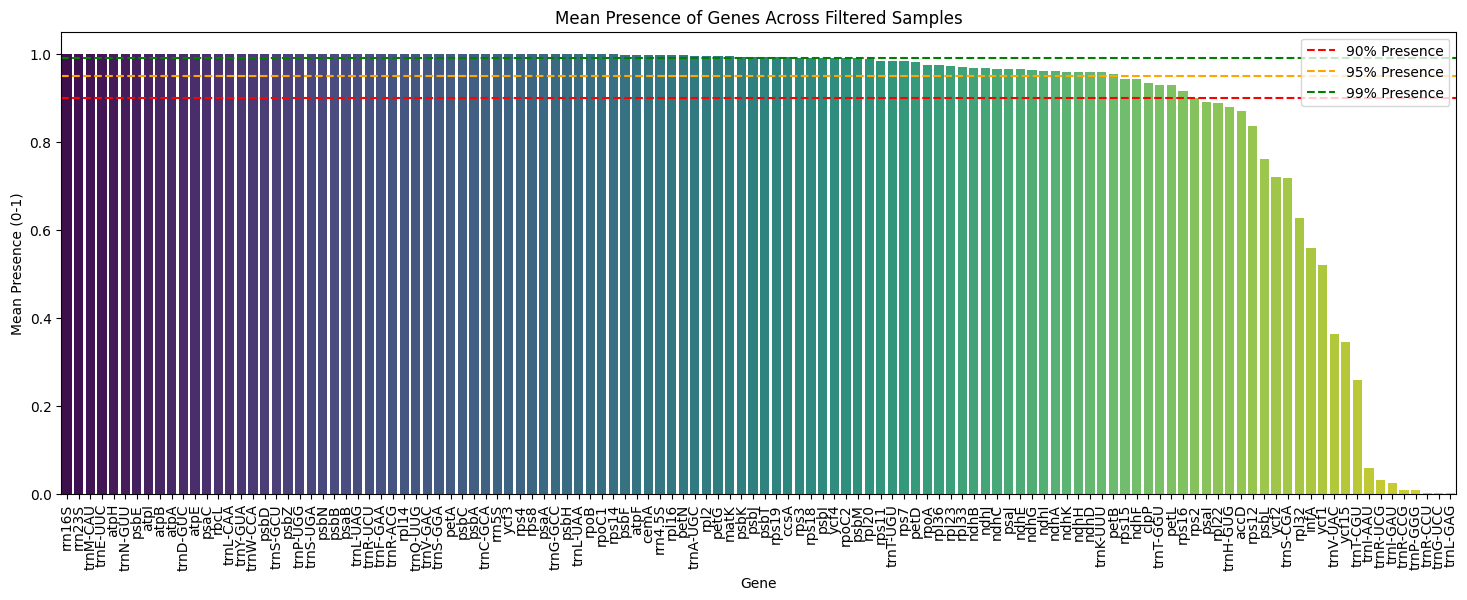

Number of genes present in >90% of samples: 98
Number of genes present in >95% of samples: 91
Number of genes present in >98% of samples: 74
Number of genes present in >99% of samples: 67


In [29]:
gene_presence_columns = [col[:-4] for col in df_filtered.columns if col.endswith("_CDS")]
print(f"Number of GENE columns: {len(gene_presence_columns)}")

#find and plot the mean presence/absence of each gene in gene_presence_columns
gene_means = df_filtered[gene_presence_columns].mean().sort_values(ascending=False)
plt.figure(figsize=(18,6))
sns.barplot(x=gene_means.index, y=gene_means.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Mean Presence (0-1)")
plt.title("Mean Presence of Genes Across Filtered Samples")

#put a horizontal line at y=0.9, 0.95, and 0.99
plt.axhline(0.9, color='red', linestyle='--', label='90% Presence')
plt.axhline(0.95, color='orange', linestyle='--', label='95% Presence')
plt.axhline(0.99, color='green', linestyle='--', label='99% Presence')
plt.legend()

plt.show()

#how many genes are present in > 90% of samples, >95%, >99%
num_genes_90 = (gene_means > 0.9).sum()
num_genes_95 = (gene_means > 0.95).sum()
num_genes_98 = (gene_means > 0.98).sum()
num_genes_99 = (gene_means > 0.99).sum()
print(f"Number of genes present in >90% of samples: {num_genes_90}")
print(f"Number of genes present in >95% of samples: {num_genes_95}")
print(f"Number of genes present in >98% of samples: {num_genes_98}")
print(f"Number of genes present in >99% of samples: {num_genes_99}")

In [30]:
df_filtered["psbA_outlier"].value_counts()

psbA_outlier
False    10783
True        74
Name: count, dtype: int64

Number of GENE columns: 120


/tmp/ipykernel_681453/3210648308.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  corrected_presence[gene] = (df_filtered[gene] == 1) & (df_filtered[outlier_col] == False)
/tmp/ipykernel_681453/3210648308.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  corrected_presence[gene] = (df_filtered[gene] == 1) & (df_filtered[outlier_col] == False)
/tmp/ipykernel_681453/3210648308.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

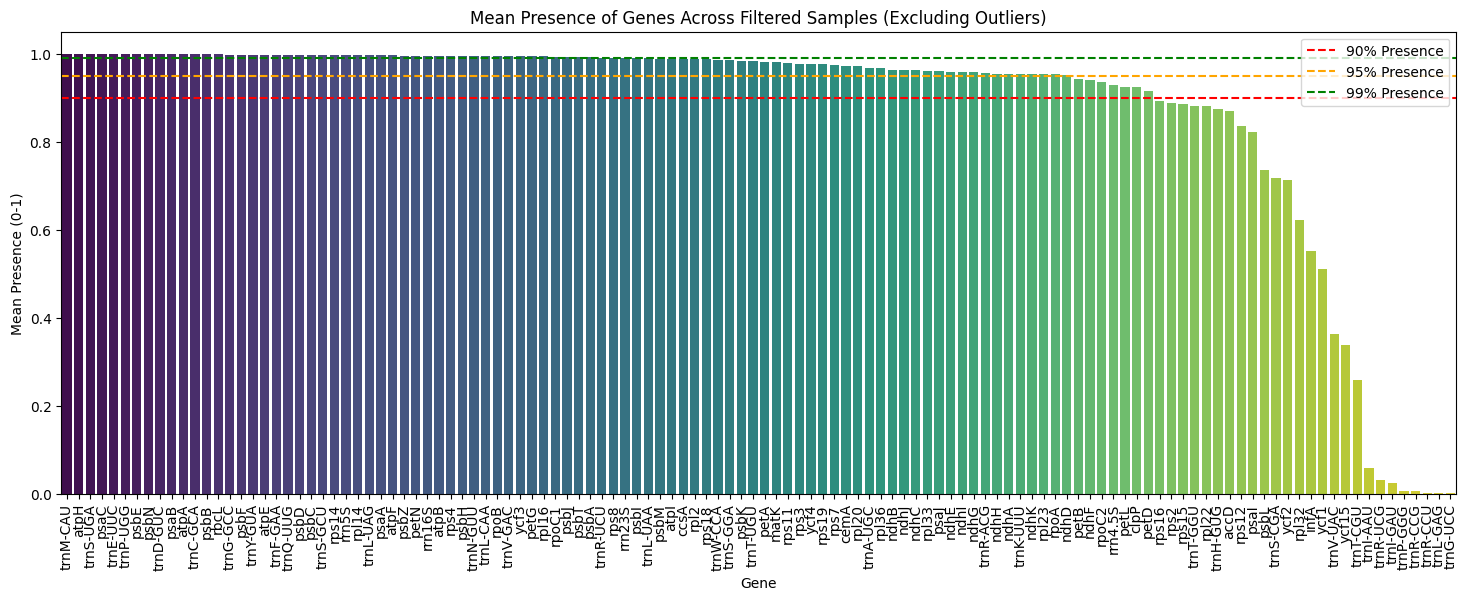

Number of genes present in >90% of samples: 94
Number of genes present in >95% of samples: 87
Number of genes present in >98% of samples: 62
Number of genes present in >99% of samples: 48


In [31]:
# Identify CDS columns
gene_presence_columns = [col[:-4] for col in df_filtered.columns if col.endswith("_CDS")]
print(f"Number of GENE columns: {len(gene_presence_columns)}")

# Build corrected presence matrix:
# presence = 1 only if CDS==1 and outlier==False
corrected_presence = pd.DataFrame(index=df_filtered.index)

for gene in gene_presence_columns:
    outlier_col = f"{gene}_outlier"
    
    if outlier_col in df_filtered.columns:
        corrected_presence[gene] = (df_filtered[gene] == 1) & (df_filtered[outlier_col] == False)
    else:
        # fallback: just use the CDS if no outlier col
        corrected_presence[gene] = (df_filtered[gene] == 1)

# Convert to integers (0/1)
corrected_presence = corrected_presence.astype(int)

# Compute mean presence across samples
gene_means = corrected_presence.mean().sort_values(ascending=False)

# ---- PLOTTING ----
plt.figure(figsize=(18,6))
sns.barplot(x=gene_means.index, y=gene_means.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Gene")
plt.ylabel("Mean Presence (0-1)")
plt.title("Mean Presence of Genes Across Filtered Samples (Excluding Outliers)")

# Threshold lines
plt.axhline(0.9, color='red', linestyle='--', label='90% Presence')
plt.axhline(0.95, color='orange', linestyle='--', label='95% Presence')
plt.axhline(0.99, color='green', linestyle='--', label='99% Presence')
plt.legend()
plt.show()

# ---- SUMMARY ----
num_genes_90 = (gene_means > 0.9).sum()
num_genes_95 = (gene_means > 0.95).sum()
num_genes_98 = (gene_means > 0.98).sum()
num_genes_99 = (gene_means > 0.99).sum()

print(f"Number of genes present in >90% of samples: {num_genes_90}")
print(f"Number of genes present in >95% of samples: {num_genes_95}")
print(f"Number of genes present in >98% of samples: {num_genes_98}")
print(f"Number of genes present in >99% of samples: {num_genes_99}")


In [32]:
genes_95 = gene_means[gene_means > 0.95].index.tolist()
print(f"Genes present in >95% of samples: {len(genes_95)}")
genes_95

Genes present in >95% of samples: 87


['trnM-CAU',
 'atpH',
 'trnS-UGA',
 'psaC',
 'trnE-UUC',
 'trnP-UGG',
 'psbE',
 'psbN',
 'trnD-GUC',
 'psaB',
 'atpA',
 'trnC-GCA',
 'psbB',
 'rbcL',
 'trnG-GCC',
 'psbF',
 'trnY-GUA',
 'atpE',
 'trnF-GAA',
 'trnQ-UUG',
 'psbD',
 'psbC',
 'trnS-GCU',
 'rps14',
 'rrn5S',
 'rpl14',
 'trnL-UAG',
 'psaA',
 'atpF',
 'psbZ',
 'petN',
 'rrn16S',
 'atpB',
 'rps4',
 'psbH',
 'trnN-GUU',
 'trnL-CAA',
 'rpoB',
 'trnV-GAC',
 'ycf3',
 'petG',
 'rpl16',
 'rpoC1',
 'psbJ',
 'psbT',
 'psbA',
 'trnR-UCU',
 'rps8',
 'rrn23S',
 'psbI',
 'trnL-UAA',
 'psbM',
 'atpI',
 'ccsA',
 'rpl2',
 'rps18',
 'trnW-CCA',
 'trnS-GGA',
 'psbK',
 'trnT-UGU',
 'petA',
 'matK',
 'rps11',
 'rps3',
 'ycf4',
 'rps19',
 'rps7',
 'cemA',
 'rpl20',
 'trnA-UGC',
 'rpl36',
 'ndhB',
 'ndhJ',
 'ndhC',
 'rpl33',
 'psaJ',
 'ndhE',
 'ndhI',
 'ndhG',
 'trnR-ACG',
 'ndhH',
 'ndhA',
 'trnK-UUU',
 'ndhK',
 'rpl23',
 'rpoA',
 'ndhD']

In [ ]:
for gene in tqdm(genes_95):
    out_file = f"data/tmp/genesToAlign/{gene}_CDS.fasta"
    with open(out_file, "w") as f:
        for idx, row in df_filtered.iterrows():
            seq = row.get(f"{gene}_CDS")
            if pd.notna(seq) and seq and not row.get(f"{gene}_outlier", False):
                header = f">{row['ID']}|Gene_{gene}|Taxonomy:{row.get('Taxonomy','')}"
                f.write(f"{header}\n{seq}\n")

# ---- OPTIONAL: DROP TRN / RRN AND WRITE AA FASTAS ----
proteins = [g for g in genes_95 if "trn" not in g and "rrn" not in g]
gbfs_dir = "data/gbfs"

for g in tqdm(proteins):
    df_filtered[f"{g}_AA"] = df_filtered["FileBasename"].parallel_apply(
        lambda x: get_gene_AA_from_gbf(g, os.path.join(gbfs_dir, x + "fa.gbf"))
    )
    out_file = f"data/tmp/genesToAlign/{g}_AA.fasta"
    with open(out_file, "w") as f:
        for idx, row in df_filtered.iterrows():
            seq = row.get(f"{g}_AA")
            if pd.notna(seq) and seq and not row.get(f"{g}_outlier", False):
                header = f">{row['ID']}|Gene_{g}|Taxonomy:{row.get('Taxonomy','')}"
                f.write(f"{header}\n{seq}\n")

 10%|▉         | 6/61 [01:45<16:04, 17.53s/it]

In [1]:
#now, we want to rewrite the gene DNA and peptide sequences for alignment

#how many _CDS columns are in the df
cds_columns = [col for col in df.columns if col.endswith("_CDS")]
print(f"Number of CDS columns: {len(cds_columns)}")


NameError: name 'df' is not defined

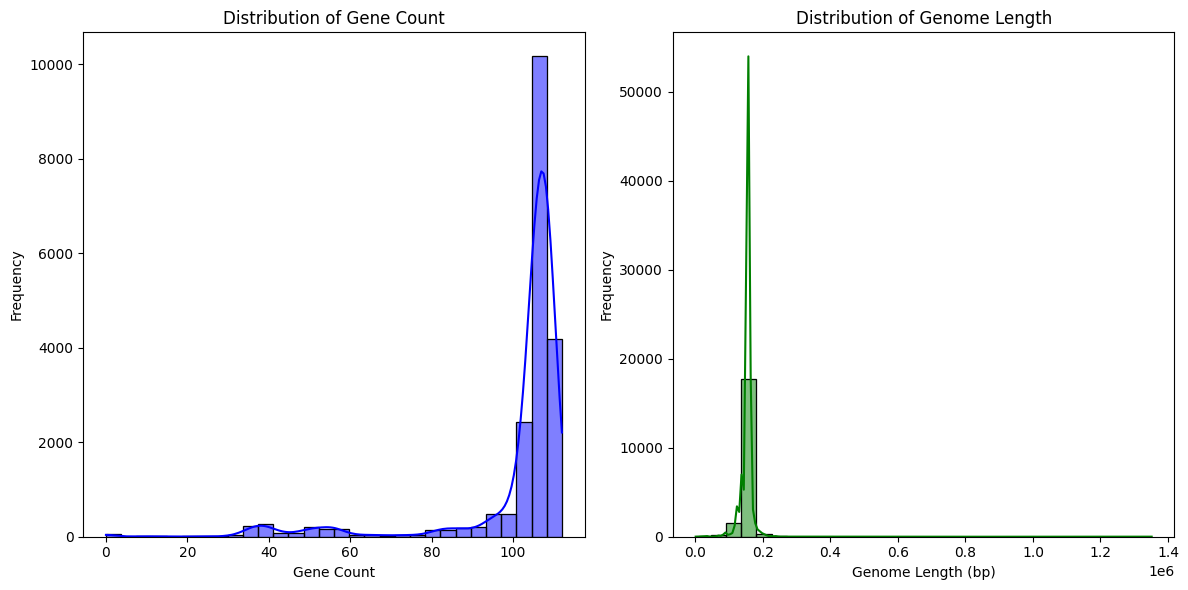

In [38]:
#hist of df gene count and genome length
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['geneCount'], bins=30, kde=True, color='blue')
plt.title('Distribution of Gene Count')
plt.xlabel('Gene Count')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df['genomeLength'], bins=30, kde=True, color='green')
plt.title('Distribution of Genome Length')
plt.xlabel('Genome Length (bp)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
%src/aligner.sh

In [13]:
#save the df_filtered to a csv
df_filtered.to_csv("data/alignment_input_data.csv", index=False)
print("Filtered dataframe saved to data/alignment_input_data.csv")

Filtered dataframe saved to data/alignment_input_data.csv


In [9]:
#checkpoint 1 - pre alignment
df = pd.read_csv("data/alignment_input_data.csv")
print(df.shape)

(18150, 471)


/tmp/ipykernel_427213/3971088482.py:2: DtypeWarning: Columns (378,390,410) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/alignment_input_data.csv")


align using mafft


src/aligner.sh nicely calls 

mafft --adjustdirection --reorder --thread 8 --auto

pixi run python src/XXX_mergeGeneAlignments.py --aln_dir data/tmp/genesAligned/ --out_parquet data/mergedAln.pq --out_gapcounts data/mergedGapcounts.csv 



In [7]:
alignment_df = pd.read_parquet("data/mergedAln.pq")
print(f"Alignment DataFrame shape: {alignment_df.shape}")

Alignment DataFrame shape: (18170, 67450)


In [13]:
#alignment_df = alignment_df.reset_index()  # moves index into a column named "index"

# Unique index values from alignment_df
alignment_genomes = alignment_df["index"].unique()

# Compare with df_filtered['FileBasename']
missing_in_filtered = set(alignment_genomes) - set(df["ID"])
duplicates_in_alignment = alignment_df["index"][alignment_df["index"].duplicated()].unique()

print("Missing in filtered:", len(missing_in_filtered))
print("Duplicates in alignment:", len(duplicates_in_alignment))

Missing in filtered: 20
Duplicates in alignment: 0


In [15]:
#how many of the genomes in alignment_df contain "_R_"
r_count = sum(1 for genome in alignment_genomes if "_R_" in genome)
print(f"Number of genomes in alignment_df containing '_R_': {r_count}")

Number of genomes in alignment_df containing '_R_': 20


In [14]:
missing_in_filtered

{'_R_KM527889.1',
 '_R_KY000001.1',
 '_R_KY399983.1',
 '_R_LC521967.1',
 '_R_MH392274.1',
 '_R_MK415796.1',
 '_R_MK415798.1',
 '_R_MT773597.1',
 '_R_MZ678242.1',
 '_R_NC_080995.1',
 '_R_NC_088442.1',
 '_R_NC_088443.1',
 '_R_OK326868.1',
 '_R_OK539751.1',
 '_R_OK539755.1',
 '_R_OL674107.1',
 '_R_OL790354.1',
 '_R_OM761955.1',
 '_R_OR521090.1',
 '_R_PP697879.1'}

In [16]:
#if I remove _R_ from these genomes, how many are found in the filtered df?
alignment_genomes_no_r = [genome.replace("_R_", "") for genome in alignment_genomes]
missing_in_filtered_no_r = set(alignment_genomes_no_r) - set(df["ID"])
print(f"Number of genomes in alignment_df (with '_R_' removed) missing in filtered: {len(missing_in_filtered_no_r)}")

Number of genomes in alignment_df (with '_R_' removed) missing in filtered: 0


In [20]:
is_r = alignment_df["index"].str.startswith("_R_")

alignment_df_r = alignment_df.loc[is_r]

# Random sample of 20 from NON-_R_ genomes (if you specifically want to compare to non-_R_)
non_r = alignment_df.loc[~is_r]
alignment_df_rand_nonr = non_r.sample(n=min(20, len(non_r)), random_state=42)

# --- Compute per-row gap counts and fractions ---
# assumes gaps are stored as '-' (your Python pre-processing already translated ambigs to '-')
gaps_per_row = (alignment_df.iloc[:, 1:] == '-').sum(axis=1)
sites = alignment_df.shape[1]
gap_frac_per_row = gaps_per_row / sites

# Extract stats for each group
r_gap_counts = gaps_per_row.loc[alignment_df_r.index]
r_gap_fracs  = gap_frac_per_row.loc[alignment_df_r.index]

rand_nonr_gap_counts = gaps_per_row.loc[alignment_df_rand_nonr.index]
rand_nonr_gap_fracs  = gap_frac_per_row.loc[alignment_df_rand_nonr.index]

# --- Quick summaries ---
print("Total gaps across _R_ genomes:", int(r_gap_counts.sum()))
print("Median gaps per _R_ genome:", float(r_gap_counts.median()),
      f"({r_gap_fracs.median():.3%} of sites)")

print("Random 20 (non-_R_): median gaps:",
      float(rand_nonr_gap_counts.median()),
      f"({rand_nonr_gap_fracs.median():.3%})")

Total gaps across _R_ genomes: 1347786
Median gaps per _R_ genome: 67387.0 (99.904% of sites)
Random 20 (non-_R_): median gaps: 4653.0 (6.898%)


In [19]:
r_gap_fracs


Series([], dtype: float64)

In [26]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def get_sites_from_alignment_fasta(aln_file, samples_per_site=0.9):
    """
    prepare an alignment for an association study
    :param aln_file: path to alignment file
    :param samples_per_site: minimum proportion of samples with a site to keep it

    :return: a pandas DataFrame with the alignment, where each column is a site and each row is a sample
    #the column names should be fastaFileBasename_idx 
    """
    # read the alignment
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    # get the alignment length
    aln_len = len(aln[0].seq)

    #assert that all sequences have the same length
    for record in aln:
        assert len(record.seq) == aln_len, 'Sequences have different lengths'

    # create a dictionary to store the alignment
    aln_dict = {i: [''] * aln_len for i in range(len(aln))}

    # fill the dictionary
    for i, record in tqdm(enumerate(aln)):
        aln_dict[i] = list(record.seq.upper())

    # create a DataFrame
    aln_df = pd.DataFrame(aln_dict).T

    # rename the columns
    fastabasename = os.path.basename(aln_file).split("_")[0]
    aln_df.columns = [f"{fastabasename}_alnSite_{i}" for i in aln_df.columns]

    #rename the rows
    aln_df.index = [record.id.split("|")[0] for record in aln]

    ambig = ['W','Y','K','S','M','N','R']
    aln_df = aln_df.replace({a:'-' for a in ambig})

    # remove sites with too many missing data (encoded as "-", or gaps )
    print("Removing sites with too many missing data")
    print("Before removing sites:", aln_df.shape)
    #remove sites with too many missing data
    aln_df = aln_df.loc[:, (aln_df == '-').mean() < (1 - samples_per_site)]

    print("After removing sites:", aln_df.shape)

    return aln_df


In [27]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def get_sites_from_alignment_fasta_nofilter(aln_file):
    """
    prepare an alignment for an association study
    :param aln_file: path to alignment file
    :param samples_per_site: minimum proportion of samples with a site to keep it

    :return: a pandas DataFrame with the alignment, where each column is a site and each row is a sample
    #the column names should be fastaFileBasename_idx 
    """
    # read the alignment
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    # get the alignment length
    aln_len = len(aln[0].seq)

    #assert that all sequences have the same length
    for record in aln:
        assert len(record.seq) == aln_len, 'Sequences have different lengths'

    # create a dictionary to store the alignment
    aln_dict = {i: [''] * aln_len for i in range(len(aln))}

    # fill the dictionary
    for i, record in tqdm(enumerate(aln)):
        aln_dict[i] = list(record.seq.upper())

    # create a DataFrame
    aln_df = pd.DataFrame(aln_dict).T

    # rename the columns
    fastabasename = os.path.basename(aln_file).split("_")[0]
    aln_df.columns = [f"{fastabasename}_alnSite_{i}" for i in aln_df.columns]

    #rename the rows
    aln_df.index = [record.id.split("|")[0] for record in aln]

    ambig = ['W','Y','K','S','M','N','R']
    aln_df = aln_df.replace({a:'-' for a in ambig})

    # remove sites with too many missing data (encoded as "-", or gaps )
    #print("Removing sites with too many missing data")
    print("aln_shape:", aln_df.shape)
    #remove sites with too many missing data
    #aln_df = aln_df.loc[:, (aln_df == '-').mean() < (1 - samples_per_site)]

    #print("After removing sites:", aln_df.shape)

    return aln_df


In [28]:
aln_file = "data/tmp/genesAligned/rbcL_CDS_aligned.fasta"
aln_df = get_sites_from_alignment_fasta_nofilter(aln_file)
print(aln_df.shape)
aln_df


17902it [00:00, 123024.74it/s]


aln_shape: (17902, 1895)
(17902, 1895)


,rbcL_alnSite_0,rbcL_alnSite_1,rbcL_alnSite_2,rbcL_alnSite_3,rbcL_alnSite_4,rbcL_alnSite_5,rbcL_alnSite_6,rbcL_alnSite_7,rbcL_alnSite_8,rbcL_alnSite_9,...,rbcL_alnSite_1885,rbcL_alnSite_1886,rbcL_alnSite_1887,rbcL_alnSite_1888,rbcL_alnSite_1889,rbcL_alnSite_1890,rbcL_alnSite_1891,rbcL_alnSite_1892,rbcL_alnSite_1893,rbcL_alnSite_1894
PX058852.1,A,T,G,A,G,T,T,G,T,A,...,-,-,-,-,-,-,-,-,-,-
PX058850.1,A,T,G,A,G,T,T,G,T,A,...,-,-,-,-,-,-,-,-,-,-
MF197310.1,A,T,G,A,G,T,T,G,T,A,...,-,-,-,-,-,-,-,-,-,-
PX058851.1,A,T,G,A,G,T,T,G,T,A,...,-,-,-,-,-,-,-,-,-,-
KJ566306.1,A,T,G,A,G,T,T,G,T,A,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MZ221902.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
NC_086775.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
NC_077577.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
OL813726.1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


Unique values in alignment: ['A' 'T' 'G' '-' 'C']


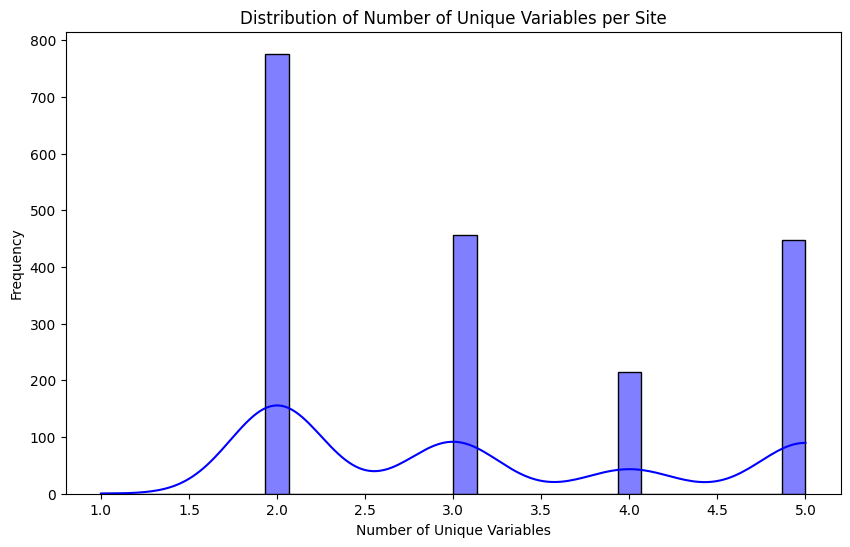

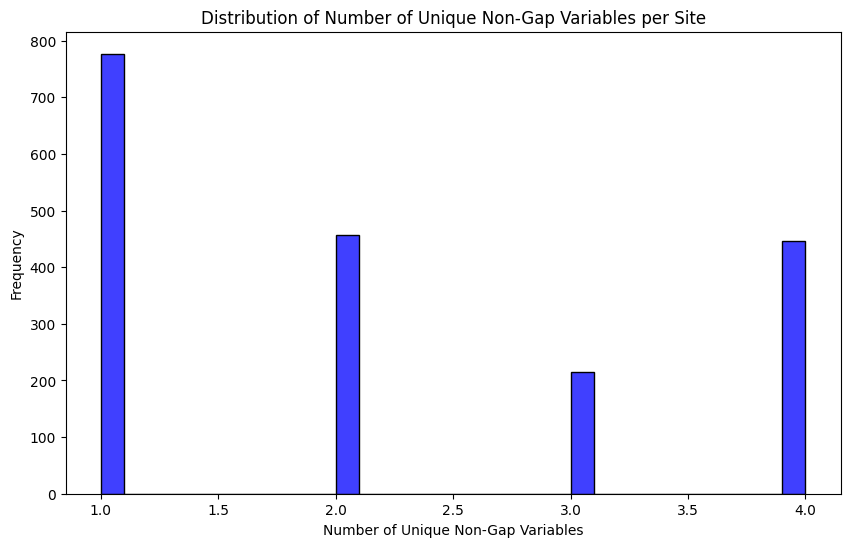

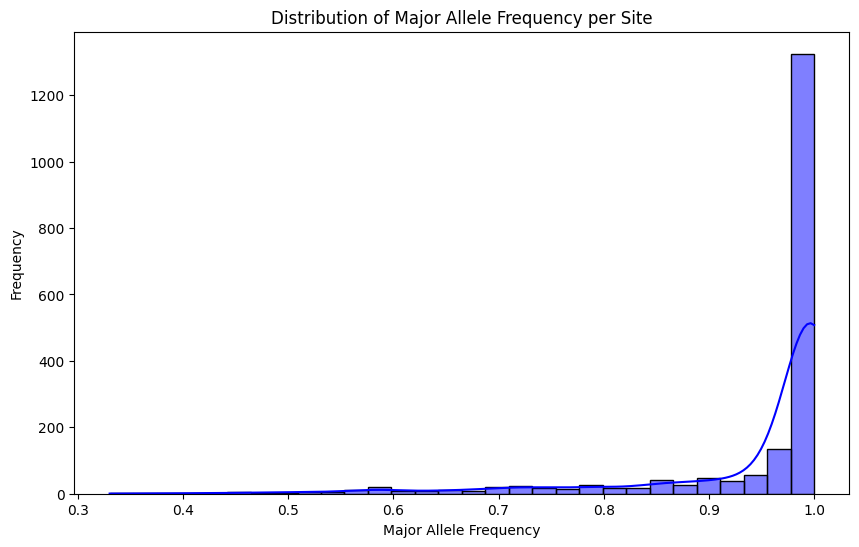

In [29]:
#what are all the unique values in the alignment
unique_values = pd.Series(aln_df.values.ravel()).unique()
print(f"Unique values in alignment: {unique_values}")

#measure the number of unique variables per site and plot a histogram
num_unique = aln_df.nunique()
plt.figure(figsize=(10,6))
sns.histplot(num_unique, bins=30, kde=True, color='blue')
plt.title('Distribution of Number of Unique Variables per Site')
plt.xlabel('Number of Unique Variables')
plt.ylabel('Frequency')

#number of unique non-gap values per site
def count_unique_non_gap(series):
    return series[series != '-'].nunique()

num_unique_non_gap = aln_df.apply(count_unique_non_gap)
plt.figure(figsize=(10,6))
sns.histplot(num_unique_non_gap, bins=30, kde=False, color='blue')
plt.title('Distribution of Number of Unique Non-Gap Variables per Site')
plt.xlabel('Number of Unique Non-Gap Variables')
plt.ylabel('Frequency')
plt.show()

#plot of major allele frequency histogram
def major_allele_frequency(series): 
    counts = series.value_counts()
    if len(counts) == 0:
        return 0
    return counts.iloc[0] / counts.sum()

maf = aln_df.parallel_apply(major_allele_frequency)
plt.figure(figsize=(10,6))
sns.histplot(maf, bins=30, kde=True, color='blue')
plt.title('Distribution of Major Allele Frequency per Site')
plt.xlabel('Major Allele Frequency')
plt.ylabel('Frequency')
plt.show()

In [ ]:
aln_dir = "data/tmp/genesAligned"
aln_files = glob.glob(f"{aln_dir}/*.fasta")

supermatrix = pd.DataFrame()

for f in tqdm(aln_files):
    aln_df = get_sites_from_alignment_fasta_nofilter(f)
    gene_name = os.path.splitext(os.path.basename(f))[0].split("_")[0]
    aln_df.columns = [f"{gene_name}_alnSite_{i}" for i in range(aln_df.shape[1])]
    
    if supermatrix.empty:
        supermatrix = aln_df
    else:
        supermatrix = supermatrix.merge(aln_df, left_index=True, right_index=True, how='outer')
        supermatrix.fillna('-', inplace=True)

print("Supermatrix shape:", supermatrix.shape)
supermatrix

In [ ]:
f

'data/tmp/genesAligned/rpoC2_CDS_aligned_linsi.fasta'

In [ ]:
dinucs = [a+b for a in 'ACTG' for b in 'ACTG']

def compute_freq(seq):
    try:
        counts = dict.fromkeys(dinucs, 0)
        for i in range(len(seq)-1):
            dp = seq[i:i+2]
            if dp in counts:
                counts[dp] += 1
        total = sum(counts.values())
        return {f"dinucleotide_{dp}": counts[dp]/total if total>0 else 0 for dp in dinucs}
    except Exception as e:
        #print(f"Error computing dinucleotide frequencies: {e}")
        #print(f"Sequence: {seq}")
        return {f"dinucleotide_{dp}": None for dp in dinucs}

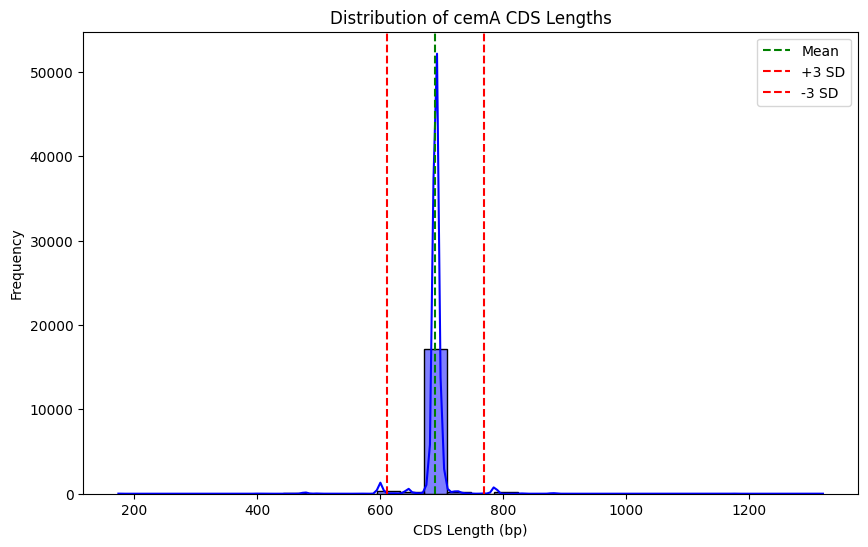

In [ ]:
#now, let's walk through preparing genes for alignment. Let's pick cemA
# which is a good candidate for this process because it's a little variable 

#theres two things I think we need to catch that can manifest in annotation errors; really long/short genes,
# and really wacko genes that have look very different. 

#df["cemA_CDS"] has the CDS DNA sequence
#df["cemA_CDS"] 

#plot the histogram of the lengths of the cemA CDS sequences
cemA_lengths = df["cemA_CDS"].str.len()
plt.figure(figsize=(10,6))
sns.histplot(cemA_lengths, bins=30, kde=True, color='blue')
plt.axvline(cemA_lengths.mean(), color='green', linestyle='dashed',
            label='Mean')
plt.axvline(cemA_lengths.mean() + 3 * cemA_lengths.std(), color='red', linestyle='dashed',
            label='+3 SD')
plt.axvline(cemA_lengths.mean() - 3 * cemA_lengths.std(), color='red', linestyle='dashed',
            label='-3 SD')
plt.title('Distribution of cemA CDS Lengths')
plt.xlabel('CDS Length (bp)')
plt.ylabel('Frequency')
plt.legend()

#okay actually cemA looks great. 

(19908, 16)
(18144, 16)


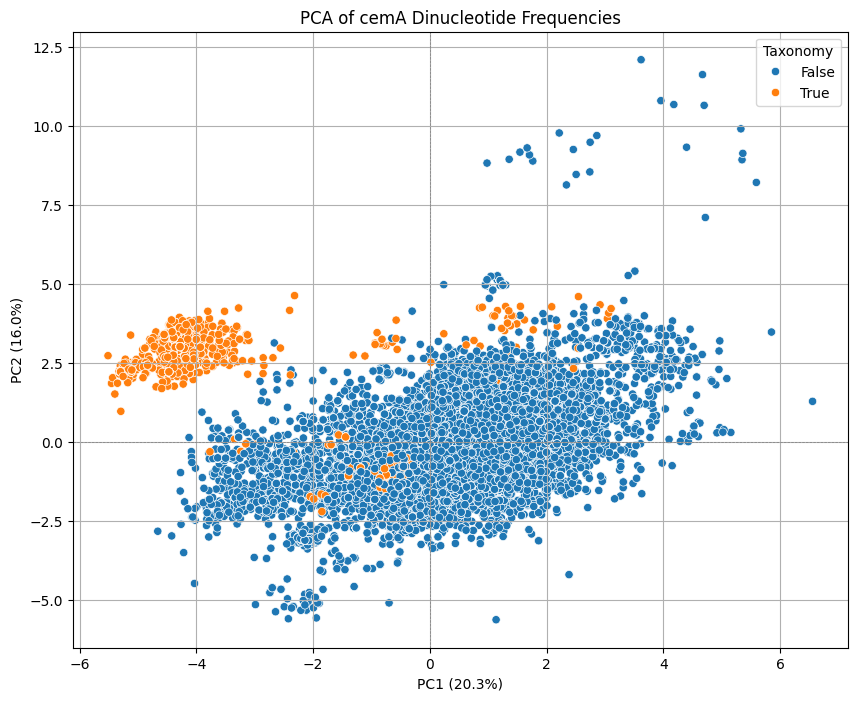

Explained variance:
PC1: 20.28%
PC2: 15.96%

Top genes contributing to PC1:
cemA_dinucleotide_TA    0.464514
cemA_dinucleotide_AT    0.447893
cemA_dinucleotide_GG    0.360457
cemA_dinucleotide_CT    0.331283
cemA_dinucleotide_TG    0.318114
cemA_dinucleotide_AG    0.269560
cemA_dinucleotide_CG    0.207106
cemA_dinucleotide_GA    0.194159
cemA_dinucleotide_AA    0.165201
cemA_dinucleotide_GC    0.131445
Name: PC1, dtype: float64

Top genes contributing to PC2:
cemA_dinucleotide_TT    0.526033
cemA_dinucleotide_TC    0.444815
cemA_dinucleotide_GA    0.315164
cemA_dinucleotide_AA    0.308967
cemA_dinucleotide_CC    0.274264
cemA_dinucleotide_CA    0.249611
cemA_dinucleotide_CG    0.247314
cemA_dinucleotide_AT    0.197131
cemA_dinucleotide_TA    0.180116
cemA_dinucleotide_AG    0.165199
Name: PC2, dtype: float64


In [ ]:
# now, let's process it's dinucleotide frequencies, and perform a PCA on the dinucleotide frequencies
# to see if we can find any outliers
freq_df = df['cemA_CDS'].parallel_apply(compute_freq).apply(pd.Series)
#rename these columns to have a prefix
freq_df = freq_df.add_prefix('cemA_')
print(freq_df.shape)


#and drop all the rows that are all None
freq_df = freq_df.dropna(axis=0, how='all')
print(freq_df.shape)
#get the freq_df columns
dinuc_cols = freq_df.columns.tolist()
#let's do PCA on the dinucleotide frequencies

scaler = StandardScaler()
scaled_freq = scaler.fit_transform(freq_df)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled_freq)
plt.figure(figsize=(10,8))
poales_mask = df.loc[freq_df.index, 'Taxonomy'].str.contains('Poales;', na=False)
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=poales_mask)
#scale = 13
#plt.xlim(-scale, scale)
#plt.ylim(-scale, scale)



plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA of cemA Dinucleotide Frequencies')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

plt.grid()
plt.show()

#df = pd.concat([df, freq_df], axis=1)

#dinucs_prefixed = [f"cemA_dinucleotide_{a+b}" for a in 'ACTG' for b in 'ACTG']
#centroid = df[dinucs_prefixed].mean()
#df['DistanceToCentroid'] = np.linalg.norm(df[dinucs_prefixed] - centroid, axis=1)

loadings = pd.DataFrame(pca.components_.T, index=dinuc_cols, columns=["PC1", "PC2"])
explained_var = pca.explained_variance_ratio_

print(f"Explained variance:\nPC1: {explained_var[0]*100:.2f}%\nPC2: {explained_var[1]*100:.2f}%\n")

print("Top genes contributing to PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(10))

print("\nTop genes contributing to PC2:")
print(loadings["PC2"].abs().sort_values(ascending=False).head(10))

(19908, 16)
(19908, 16)


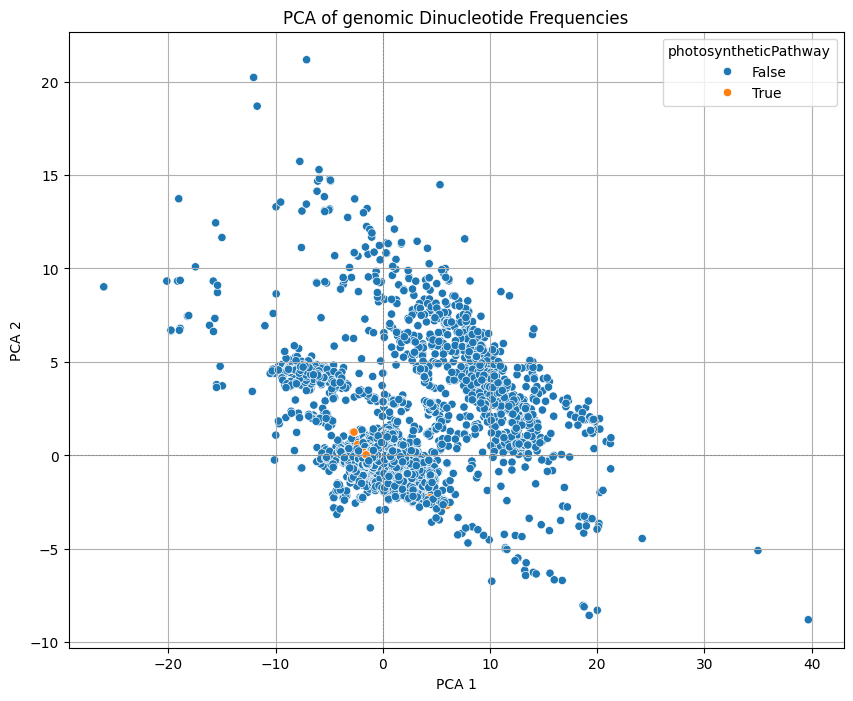

In [ ]:
# now, let's process it's dinucleotide frequencies, and perform a PCA on the dinucleotide frequencies
# to see if we can find any outliers
dinuc_cols = [f"dinucleotide_{a+b}" for a in "ACGT" for b in "ACGT"]
freq_df = df[dinuc_cols]
print(freq_df.shape)


#and drop all the rows that are all None
freq_df = freq_df.dropna(axis=0, how='all')
print(freq_df.shape)

#let's do PCA on the dinucleotide frequencies

scaler = StandardScaler()
scaled_freq = scaler.fit_transform(freq_df)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled_freq)
plt.figure(figsize=(10,8))
poales_mask = df.loc[freq_df.index, 'photosyntheticPathway'].str.contains('C4', na=False)
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=poales_mask)
#scale = 13
#plt.xlim(-scale, scale)
#plt.ylim(-scale, scale)



plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA of genomic Dinucleotide Frequencies')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()

#df = pd.concat([df, freq_df], axis=1)

#dinucs_prefixed = [f"cemA_dinucleotide_{a+b}" for a in 'ACTG' for b in 'ACTG']
#centroid = df[dinucs_prefixed].mean()
#df['DistanceToCentroid'] = np.linalg.norm(df[dinucs_prefixed] - centroid, axis=1)

In [ ]:
#I hypothesize that these small outliers will be things I don't want to align, but first I will align all these things, removing based on length
#write all cemA CDS sequences to a file if the length is not an outlier
with open("data/tmp/genesToAlign/cemA_CDS.fasta", "w") as f:
    for index, row in tqdm(df.iterrows()):
        if not row["cemA_outlier"] and pd.notna(row["cemA_CDS"]):
            pass
            #f.write(f">{row['ID']}\n{row['cemA_CDS']}\n")
            



19908it [00:01, 13395.95it/s]


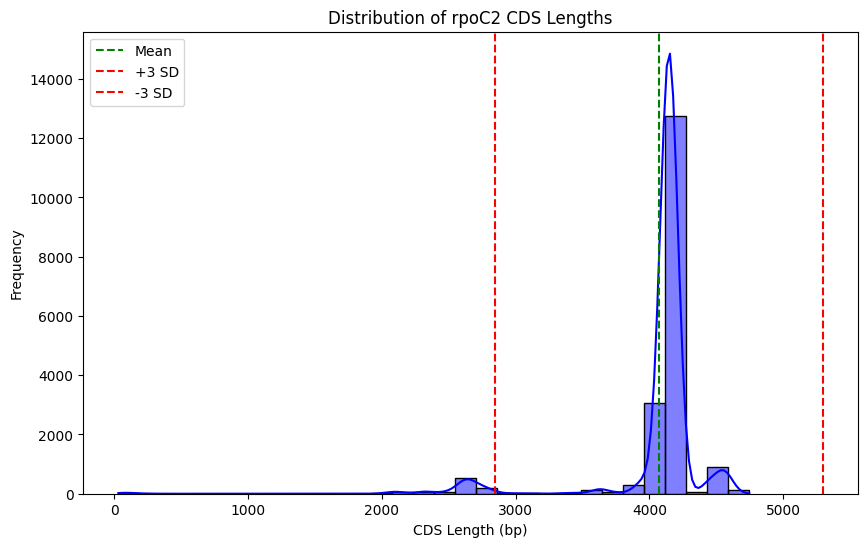

In [ ]:
#That was actually like a beautiful alignment, which is not great for establishing filtering criteria

lengths = df["rpoC2_CDS"].str.len()
plt.figure(figsize=(10,6))
sns.histplot(lengths, bins=30, kde=True, color='blue')
plt.axvline(lengths.mean(), color='green', linestyle='dashed',
            label='Mean')
plt.axvline(lengths.mean() + 3 * lengths.std(), color='red', linestyle='dashed',
            label='+3 SD')
plt.axvline(lengths.mean() - 3 * lengths.std(), color='red', linestyle='dashed',
            label='-3 SD')
plt.title('Distribution of rpoC2 CDS Lengths')
plt.xlabel('CDS Length (bp)')
plt.ylabel('Frequency')
plt.legend()

(19908, 16)
(18348, 16)


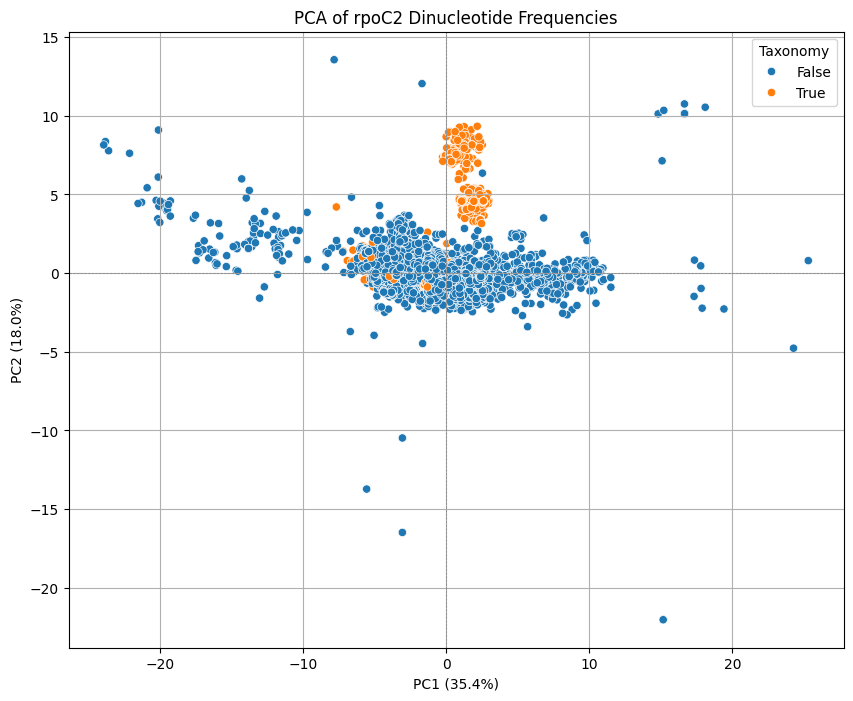

Explained variance:
PC1: 35.40%
PC2: 17.99%

Top genes contributing to PC1:
rpoC2_dinucleotide_GG    0.342860
rpoC2_dinucleotide_TA    0.340402
rpoC2_dinucleotide_TT    0.339351
rpoC2_dinucleotide_GC    0.337933
rpoC2_dinucleotide_CG    0.332698
rpoC2_dinucleotide_AT    0.324712
rpoC2_dinucleotide_AA    0.317017
rpoC2_dinucleotide_CC    0.300998
rpoC2_dinucleotide_CT    0.173402
rpoC2_dinucleotide_GA    0.168901
Name: PC1, dtype: float64

Top genes contributing to PC2:
rpoC2_dinucleotide_AG    0.451666
rpoC2_dinucleotide_TG    0.441291
rpoC2_dinucleotide_GT    0.395840
rpoC2_dinucleotide_CA    0.392160
rpoC2_dinucleotide_GA    0.357819
rpoC2_dinucleotide_AA    0.204567
rpoC2_dinucleotide_AT    0.189119
rpoC2_dinucleotide_TC    0.183272
rpoC2_dinucleotide_AC    0.157684
rpoC2_dinucleotide_CT    0.148297
Name: PC2, dtype: float64


In [ ]:
freq_df = df['rpoC2_CDS'].parallel_apply(compute_freq).apply(pd.Series)
#rename these columns to have a prefix
freq_df = freq_df.add_prefix('rpoC2_')
print(freq_df.shape)

freq_df = freq_df.dropna(axis=0, how='all')
print(freq_df.shape)
dinuc_cols = freq_df.columns.tolist()
#let's do PCA on the dinucleotide frequencies

scaler = StandardScaler()
scaled_freq = scaler.fit_transform(freq_df)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled_freq)
plt.figure(figsize=(10,8))
poales_mask = df.loc[freq_df.index, 'Taxonomy'].str.contains('Poales;', na=False)
sns.scatterplot(x=scores[:, 0], y=scores[:, 1], hue=poales_mask)
#scale = 13
#plt.xlim(-scale, scale)
#plt.ylim(-scale, scale)


plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA of rpoC2 Dinucleotide Frequencies')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

plt.grid()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=dinuc_cols, columns=["PC1", "PC2"])
explained_var = pca.explained_variance_ratio_

print(f"Explained variance:\nPC1: {explained_var[0]*100:.2f}%\nPC2: {explained_var[1]*100:.2f}%\n")

print("Top genes contributing to PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(10))

print("\nTop genes contributing to PC2:") 
print(loadings["PC2"].abs().sort_values(ascending=False).head(10))

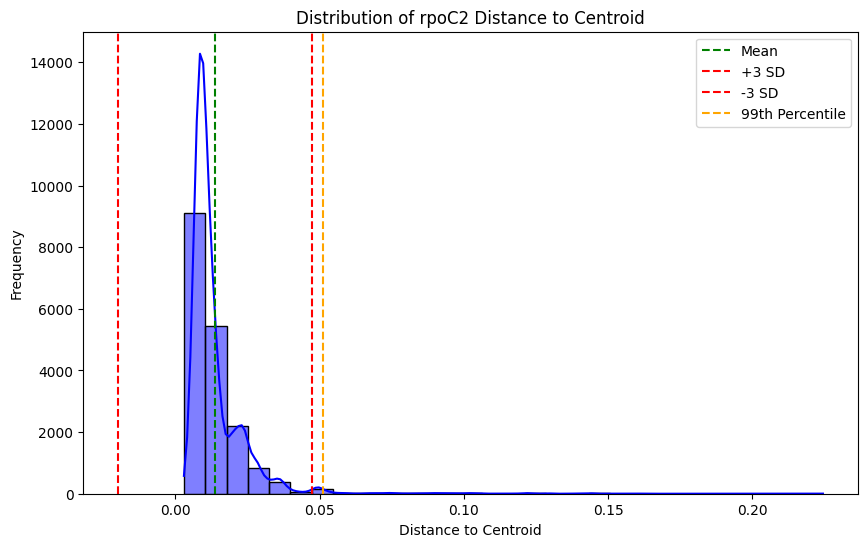

In [ ]:
dinucs_prefixed = [f"rpoC2_dinucleotide_{a+b}" for a in 'ACTG' for b in 'ACTG']
centroid = freq_df[dinucs_prefixed].mean()
freq_df['DistanceToCentroid'] = np.linalg.norm(freq_df[dinucs_prefixed] - centroid, axis=1)

freq_df['DistanceToCentroid'].describe()

plt.figure(figsize=(10,6))
sns.histplot(freq_df['DistanceToCentroid'], bins=30, kde=True, color='blue')
plt.axvline(freq_df['DistanceToCentroid'].mean(), color='green', linestyle='dashed',
            label='Mean')
plt.axvline(freq_df['DistanceToCentroid'].mean() + 3 * freq_df['DistanceToCentroid'].std(), color='red', linestyle='dashed',
            label='+3 SD')
plt.axvline(freq_df['DistanceToCentroid'].mean() - 3 * freq_df['DistanceToCentroid'].std(), color='red', linestyle='dashed',
            label='-3 SD')

#put a line on the 90th percentile
percentile_99 = np.percentile(freq_df['DistanceToCentroid'], 99)
plt.axvline(percentile_99, color='orange', linestyle='dashed', label='99th Percentile')
plt.title('Distribution of rpoC2 Distance to Centroid')
plt.xlabel('Distance to Centroid')
plt.ylabel('Frequency')
plt.legend()

#how many 

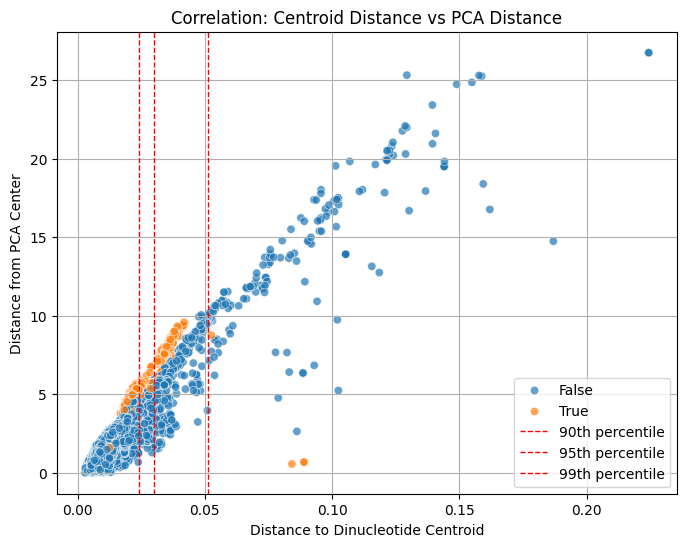

Pearson correlation: 0.926


In [ ]:
# Compute Distance from PCA center
pca_center = np.array([0, 0])
freq_df['DistanceToPCA'] = np.linalg.norm(scores - pca_center, axis=1)

# Percentiles to mark
percentiles = [90, 95, 99]
percentile_values = np.percentile(freq_df['DistanceToCentroid'], percentiles)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=freq_df['DistanceToCentroid'],
    y=freq_df['DistanceToPCA'],
    hue=poales_mask,
    alpha=0.7
)

# Add vertical lines at each percentile
for p_val, p in zip(percentile_values, percentiles):
    plt.axvline(x=p_val, color='red', linestyle='--', linewidth=1, label=f'{p}th percentile')

plt.xlabel('Distance to Dinucleotide Centroid')
plt.ylabel('Distance from PCA Center')
plt.title('Correlation: Centroid Distance vs PCA Distance')
plt.grid(True)
plt.legend()
plt.show()

# Optional: print correlation coefficient
corr = freq_df[['DistanceToCentroid','DistanceToPCA']].corr().iloc[0,1]
print(f"Pearson correlation: {corr:.3f}")


In [ ]:
freq_df = df['rpoC2_CDS'].parallel_apply(compute_freq).apply(pd.Series).add_prefix('rpoC2_').dropna(axis=0, how='all')
dinucs_prefixed = [f"rpoC2_dinucleotide_{a+b}" for a in 'ACTG' for b in 'ACTG']
centroid = freq_df[dinucs_prefixed].mean()
freq_df['DistanceToCentroid'] = np.linalg.norm(freq_df[dinucs_prefixed] - centroid, axis=1)
threshold = np.percentile(freq_df['DistanceToCentroid'], 90)
with open("data/tmp/genesToAlign/rpoC2_CDS.fasta", "w") as f:
    for idx, row in tqdm(df.iterrows()):
        if not row["rpoC2_outlier"] and pd.notna(row["rpoC2_CDS"]) and "Streptophyta" in str(row["Taxonomy"]) and freq_df.loc[idx, 'DistanceToCentroid'] <= threshold:
            f.write(f">{row['ID']}\n{row['rpoC2_CDS']}\n")


#now we need to call from shell

#begin at 9:43
/programs/mafft/bin/mafft --adjustdirection --reorder --thread 16 --auto data/tmp/genesToAlign/cemA_CDS.fasta > data/tmp/genesAligned/cemA_CDS_aligned.fasta




In [ ]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def get_sites_from_alignment_fasta(aln_file, samples_per_site=0.9):
    """
    prepare an alignment for an association study
    :param aln_file: path to alignment file
    :param samples_per_site: minimum proportion of samples with a site to keep it

    :return: a pandas DataFrame with the alignment, where each column is a site and each row is a sample
    #the column names should be fastaFileBasename_idx 
    """
    # read the alignment
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    # get the alignment length
    aln_len = len(aln[0].seq)

    #assert that all sequences have the same length
    for record in aln:
        assert len(record.seq) == aln_len, 'Sequences have different lengths'

    # create a dictionary to store the alignment
    aln_dict = {i: [''] * aln_len for i in range(len(aln))}

    # fill the dictionary
    for i, record in tqdm(enumerate(aln)):
        aln_dict[i] = list(record.seq.upper())

    # create a DataFrame
    aln_df = pd.DataFrame(aln_dict).T

    # rename the columns
    fastabasename = os.path.basename(aln_file).split(".")[0]
    aln_df.columns = [f"{fastabasename}_{i}" for i in aln_df.columns]

    #rename the rows
    aln_df.index = [record.id.split("_")[0] for record in aln]

    # remove sites with too many missing data (encoded as "-", or gaps )
    print("Removing sites with too many missing data")
    print("Before removing sites:", aln_df.shape)
    #remove sites with too many missing data
    aln_df = aln_df.loc[:, (aln_df == '-').mean() < (1 - samples_per_site)]

    print("After removing sites:", aln_df.shape)

    return aln_df


In [ ]:
#let's see 
aln_file = "data/tmp/genesToAlign/rbcL_CDS_aligned.fasta"
aln_df = get_sites_from_alignment_fasta(aln_file, samples_per_site=0.99)


FileNotFoundError: [Errno 2] No such file or directory: 'data/tmp/genesToAlign/rbcL_CDS_aligned.fasta'

In [ ]:
cols = [c for c in df.columns if c.endswith('_degenerate_GC') and df[c].dropna().shape[0] > 0]
means = df[cols].mean()

plt.figure(figsize=(18,6))
sns.boxplot(data=df[cols])
plt.title('Degenerate Codon GC Content by Gene')
plt.xticks(rotation=45)

for i, col in enumerate(cols):
    plt.text(i, means[col], f"{means[col]:.2f}", ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.savefig("plots/degenerate_gc_boxplot.pdf")
plt.close()

In [ ]:

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
data_imputed = imp.fit_transform(df[cols])
scaled = StandardScaler().fit_transform(data_imputed)
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled)
df['Poales'] = df['Taxonomy'].str.contains('Poales;', na=False)

plt.figure(figsize=(10,8))
sns.scatterplot(x=scores[:,0], y=scores[:,1], hue=df['Poales'])
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Degenerate Codon GC Content (Median Imputed)")
plt.grid(True)
plt.show()


In [ ]:
loadings = pd.DataFrame(pca.components_.T, index=cols, columns=["PC1", "PC2"])
explained_var = pca.explained_variance_ratio_

print(f"Explained variance:\nPC1: {explained_var[0]*100:.2f}%\nPC2: {explained_var[1]*100:.2f}%\n")

print("Top genes contributing to PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(10))

print("\nTop genes contributing to PC2:")
print(loadings["PC2"].abs().sort_values(ascending=False).head(10))

plt.figure(figsize=(10,8))
sns.scatterplot(x=scores[:,0], y=scores[:,1], hue=df['Poales'])
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
plt.title("PCA of Degenerate Codon GC Content")
plt.grid(True)

for i, gene in enumerate(loadings.index[:10]):
    x = loadings.loc[gene, "PC1"] * 3
    y = loadings.loc[gene, "PC2"] * 3
    plt.arrow(0, 0, x, y, color='red', alpha=0.7)
    plt.text(x*1.1, y*1.1, gene, color='red', fontsize=9)

plt.show()


In [ ]:
genes_to_plot = [
    "atpA_degenerate_GC","psaA_degenerate_GC","psbC_degenerate_GC",
    "psaB_degenerate_GC","psbB_degenerate_GC","atpB_degenerate_GC",
    "psbD_degenerate_GC","rbcL_degenerate_GC","rpoC1_degenerate_GC",
    "rpoB_degenerate_GC","petG_degenerate_GC","ycf4_degenerate_GC",
    "psaJ_degenerate_GC","rpl32_degenerate_GC","atpE_degenerate_GC",
    "psbH_degenerate_GC","psbL_degenerate_GC","atpH_degenerate_GC",
    "rps11_degenerate_GC","psaI_degenerate_GC"
]

plt.figure(figsize=(20, 15))
for i, gene in enumerate(genes_to_plot, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data=df, x=gene, hue="Poaceae", element="step", stat="frequency", common_norm=False)
    plt.title(gene)
plt.tight_layout()
plt.show()
